<a href="https://colab.research.google.com/github/ethangearey/nc-lora/blob/full_checkpoint/Experiment_1%2B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 1+2: Tracking Neural Collapse and Feature Rank (1); Measuring Parameter Update Rank (2)

## Experiment 1
Train deep networks (e.g., ResNet18 on CIFAR-10) with cross-entropy loss.
At each epoch, compute:
- NC metrics (Papyan et al.): NC1-NC4
- Rank of penultimate-layer feature matrix
- Spectrum of singular values (SVD) of class means and classwise features

Goal: empirically track the onset and strength of neural collapse vs. feature-space dimensionality.

## Experiment 2
- Save weight updates over training (e.g., via finite differences or gradients).
- Measure their empirical rank and SVD spectrum.
- Check if late-stage training updates concentrate into a low-rank subspace, coinciding with the emergence of NC.

Goal: evaluate whether global parameter (weight) updates show low-rank at the same time as neural collapse. Ensure that the low-rank parameter updates occur in the classifier and the layer before.


## Implementation Notes

- Finite differences are tracked in UpdateTracker, reflecting momentum effects. Gradients are not tracked in this implementation.

- Checkpointing saves model state, but does not save graphs or UpdateTracker (Experiment 1+2 data) objects due to storage concerns.

- UpdateTracker uses sliding window approach for SVD calculations due to memory issues. Window size can be toggled with max_history parameter.




In [19]:
import os
from google.colab import drive

data_path = os.environ.get("DATA_PATH", None)

# If not set, use Drive or local Colab storage
if data_path is None:
    try:
        # Uncomment below to use Drive
        drive.mount('/content/drive')
        data_path = '/content/drive/MyDrive/Colab Notebooks/experiment_data/'
    except Exception as e:
        print(f"Failed to mount Drive: {e}")
        data_path = '/content/data/'
        print("Falling back to local storage")

os.makedirs(data_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import gc
import psutil
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from torchvision import datasets, transforms
from IPython import embed

debug = False # Only runs 20 batches per epoch for debugging
checkpoint = True # if true, loads from local (Colab) checkpoint at '/content/large_checkpoint.pth'

# Random seed
seed                = 42
torch.manual_seed(seed)
np.random.seed(seed)

# CIFAR dataset parameters
im_size             = 32
padded_im_size      = 32
input_ch            = 3
C                   = 10

# Optimization Criterion
loss_name = 'CrossEntropyLoss'

# Optimization hyperparameters
lr_decay            = 0.1
lr                  = 0.1 # modify?

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
RANK_THRESHOLDS     = [0.95, 0.99]
tracked_layers      = ['fc.weight', 'layer4.1.conv2.weight']
max_history         = 50

analysis_epochs          = [1,   5,   10,   15,  20,  30,  40,  60, 80,
                            100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340,
                            341, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350]

In [21]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        if str(criterion) == 'CrossEntropyLoss()':
          loss = criterion(out, target)

        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(out,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))

        if debug and batch_idx > 20:
          break
    pbar.close()

In [22]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    all_features = []
    class_features = [[] for _ in range(C)]

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Metrics']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)
            output = model(data)

            h = features.value.data.view(data.shape[0],-1) # B CHW

            # Collect all features for rank analysis
            if computation == 'Mean':
              all_features.append(h.detach())

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                # Collect class-specific features for SVD analysis
                if computation == 'Mean':
                    class_features[c].append(h_c.detach())

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Metrics':
                    ## COV
                    # update within-class cov
                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
            M = torch.stack(mean).T
            loss /= sum(N)

            # Feature rank analysis
            all_features_tensor = torch.cat(all_features, dim=0)

            # Compute feature rank using *torch SVD*
            with torch.no_grad():
                _, S, _ = torch.linalg.svd(all_features_tensor, full_matrices=False)
                S = S[:100]  # Only keep top 100 components

            # Calculate effective rank
            normalized_sv = S / torch.sum(S)
            cumulative_energy = torch.cumsum(normalized_sv, dim=0)
            effective_ranks = {}
            for thresh in RANK_THRESHOLDS:
                effective_ranks[str(thresh)] = (torch.sum(cumulative_energy < thresh) + 1).item() # convert tensor to scalar
            graphs.feature_rank.append(effective_ranks)
            graphs.singular_values.append(S.cpu().numpy())

            # Class means SVD
            U_M, S_M, V_M = torch.svd(M, some=True)
            graphs.mean_singular_values.append(S_M.cpu().numpy())

            # Class-wise SVD analysis
            class_sv_lists = []
            for c in range(C):
                if len(class_features[c]) > 0:
                    class_feat = torch.cat(class_features[c], dim=0).to(device)
                    # Center the features
                    class_feat = class_feat - mean[c].unsqueeze(0)
                    # Compute SVD
                    try:
                        _, S_c, _ = torch.svd(class_feat, some=True)
                        class_sv_lists.append(S_c.cpu().numpy())
                    except:
                        # Handle potential numerical issues
                        class_sv_lists.append(np.zeros(min(class_feat.shape)))

            graphs.class_singular_values.append(class_sv_lists)
        elif computation == 'Metrics':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    W  = classifier.weight
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # tr{Sw Sb^-1}
    Sw = Sw.double()
    Sw += 1e-8 * torch.eye(Sw.shape[0], device=Sw.device) # add jitter for numerical sability
    Sb = Sb.double()  # Extra precision for small eigenvalues; modified orig.
    eigvec, eigval, _ = torch.linalg.svd(Sb, full_matrices=False)
    eigvec = eigvec[:, :C-1]
    eigval = eigval[:C-1]
    inv_Sb = eigvec @ torch.diag(1/eigval) @ eigvec.T
    graphs.Sw_invSb.append(torch.trace(Sw @ inv_Sb).item())

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))


In [23]:
class UpdateTracker:
    def __init__(self, model, max_history=max_history, max_components=100):
        # Configuration
        self.max_components = max_components
        self.max_history = max_history  # Only keep recent updates to save memory
        self.tracked_layers = tracked_layers
        self.first_update = True

        # Global tracking (all layers)
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.global_deltas = []  # Will use a sliding window approach

        # Layer-specific tracking
        self.layer_prev_weights = {n: model.state_dict()[n].detach().clone()
                                  for n in self.tracked_layers}
        self.layer_deltas = {n: [] for n in self.tracked_layers}

    def compute_update_rank(self, model):
        # Initialize return values
        effective_ranks = {str(t): np.nan for t in RANK_THRESHOLDS}
        effective_ranks_layer = {n: {str(t): np.nan for t in RANK_THRESHOLDS}
                               for n in self.tracked_layers}
        sv = np.full(self.max_components, np.nan)
        layer_svs = {n: np.full(min(self.max_components, model.state_dict()[n].numel()), np.nan)
                    for n in self.tracked_layers}

        # Skip if first epoch
        if self.first_update:
            print("First epoch - initializing trackers (no updates yet)")
            self.first_update = False
            return effective_ranks, sv, effective_ranks_layer, layer_svs

        # === Global computation (all layers) ===
        try:
            # Compute current update
            delta = []
            for n, p in model.named_parameters():
                param_delta = (p.detach() - self.prev_weights[n]).flatten()
                delta.append(param_delta)
            delta_vector = torch.cat(delta)

            # Check if update is too small
            update_norm = torch.norm(delta_vector).item()
            if update_norm < 1e-10:
                print("Warning: Update magnitude very small, skipping SVD")
                return effective_ranks, sv, effective_ranks_layer, layer_svs

            # Add to history (with memory management)
            self.global_deltas.append(delta_vector)
            if len(self.global_deltas) > self.max_history:
                self.global_deltas.pop(0)  # Remove oldest update

            # Perform torch SVD on recent history
            global_deltas = [d.to(device) for d in self.global_deltas] # send to device (debug)
            delta_matrix = torch.stack(self.global_deltas)

            if delta_matrix.shape[0] > 1:
                U, S, _ = torch.linalg.svd(delta_matrix, full_matrices=False)
                S = S[:self.max_components]  # Truncate
                explained_variance = torch.cumsum(S**2, dim=0) / torch.sum(S**2)

                for thresh in RANK_THRESHOLDS:
                    effective_rank = torch.sum(explained_variance < thresh).item() + 1
                    effective_ranks[str(thresh)] = effective_rank
                sv = S.cpu().numpy()

        except Exception as e:
            print(f"Error in global SVD computation: {e}")
            return effective_ranks, sv, effective_ranks_layer, layer_svs

        # === Layer-specific computation ===
        for layer_name in self.tracked_layers:
            try:
                # Compute current layer update
                current_param = model.state_dict()[layer_name]
                prev_param = self.layer_prev_weights[layer_name]
                layer_delta = (current_param - prev_param).flatten()

                # Check if layer update is too small
                layer_update_norm = torch.norm(layer_delta).item()
                if layer_update_norm < 1e-10:
                    continue

                # Add to layer history (with memory management)
                self.layer_deltas[layer_name].append(layer_delta)
                if len(self.layer_deltas[layer_name]) > self.max_history:
                    self.layer_deltas[layer_name].pop(0)  # Remove oldest update

                # Perform SVD on recent history for this layer
                if len(self.layer_deltas[layer_name]) > 1:
                    layer_deltas = [d.to(device) for d in self.layer_deltas[layer_name]] # send to device (debug)
                    layer_delta_matrix = torch.stack(self.layer_deltas[layer_name])
                    layer_n_components = min(layer_delta_matrix.shape[0], self.max_components)

                    # Use randomized SVD for efficiency
                    _, layer_S, _ = torch.linalg.svd(layer_delta_matrix, full_matrices=False)
                    layer_S = layer_S[:self.max_components] # Truncate
                    layer_explained_variance = torch.cumsum(layer_S**2, dim=0) / torch.sum(layer_S**2)

                    # Calculate effective ranks for this layer
                    for thresh in RANK_THRESHOLDS:
                        effective_ranks_layer[layer_name][str(thresh)] = (
                            torch.sum(layer_explained_variance < thresh).item() + 1
                        )
                    layer_svs[layer_name] = layer_S.cpu().numpy() # move to CPU for saving

            except Exception as e:
                print(f"Error in layer-specific SVD for {layer_name}: {e}")
                continue

        # Update previous weights for next iteration
        self.prev_weights = {n: p.detach().clone() for n, p in model.named_parameters()}
        self.layer_prev_weights = {n: model.state_dict()[n].detach().clone()
                                  for n in self.tracked_layers}

        return effective_ranks, sv, effective_ranks_layer, layer_svs

class Graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

    # Experiment 1 data
    self.feature_rank = [] # stores dict [{'0.95': rank1, '0.99': rank2}
    self.singular_values = []
    self.mean_singular_values = []
    self.class_singular_values = []

    # Global Experiment 2 data
    self.update_ranks = []
    self.update_spectra = []  # Global singular values -- None for most epochs

    # Layer-specific Experiment 2 data
    self.layer_singular_values = {n: [] for n in tracked_layers} #  -- None for most epochs
    self.layer_update_ranks = {n: [] for n in tracked_layers}


Loading checkpoint...
Checkpoint loaded, analyzing tensor devices...
Delta 0: shape=torch.Size([11173962]), device=cuda:0, norm=0.5366828441619873
Delta 1: shape=torch.Size([11173962]), device=cuda:0, norm=0.526860773563385
Delta 2: shape=torch.Size([11173962]), device=cuda:0, norm=0.516237199306488
Delta 3: shape=torch.Size([11173962]), device=cuda:0, norm=0.5066190361976624
Delta 4: shape=torch.Size([11173962]), device=cuda:0, norm=0.4960406422615051
Delta 5: shape=torch.Size([11173962]), device=cuda:0, norm=0.4872160851955414
Delta 6: shape=torch.Size([11173962]), device=cuda:0, norm=0.47795942425727844
Delta 7: shape=torch.Size([11173962]), device=cuda:0, norm=0.46913057565689087
Delta 8: shape=torch.Size([11173962]), device=cuda:0, norm=0.046620696783065796
Delta 9: shape=torch.Size([11173962]), device=cuda:0, norm=0.04633065313100815
Delta 10: shape=torch.Size([11173962]), device=cuda:0, norm=0.04624352604150772
Delta 11: shape=torch.Size([11173962]), device=cuda:0, norm=0.046156

Train		Epoch: 126 [390/390 (100%)] 	Batch Loss: 0.002003 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 20.11it/s]
Train		Epoch: 127 [390/390 (100%)] 	Batch Loss: 0.002019 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 20.30it/s]
Train		Epoch: 128 [390/390 (100%)] 	Batch Loss: 0.002544 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 20.50it/s]
Train		Epoch: 129 [390/390 (100%)] 	Batch Loss: 0.001499 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:18<00:00, 20.56it/s]
Train		Epoch: 130 [390/390 (100%)] 	Batch Loss: 0.002209 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:18<00:00, 20.58it/s]
Train		Epoch: 131 [390/390 (100%)] 	Batch Loss: 0.002049 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:18<00:00, 20.65it/s]
Train		Epoch: 132 [390/390 (100%)] 	Batch Loss: 0.001950 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:18<00:00, 20.59it/s]
Train		Epoch: 133 [390/390 (100%)] 	Batch Loss: 0.001792 	Batc

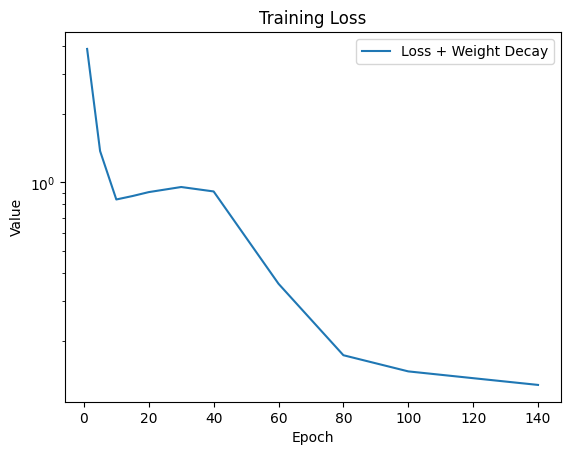

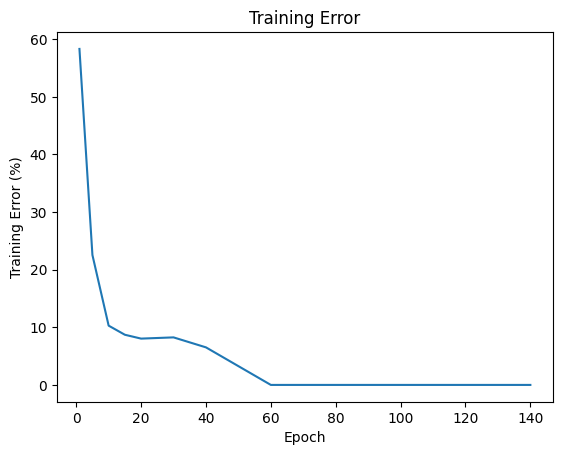

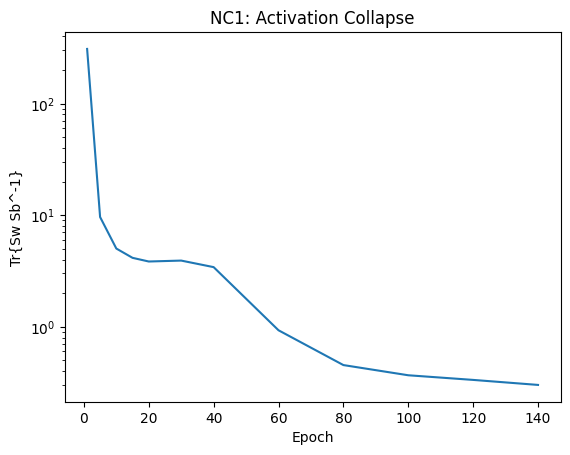

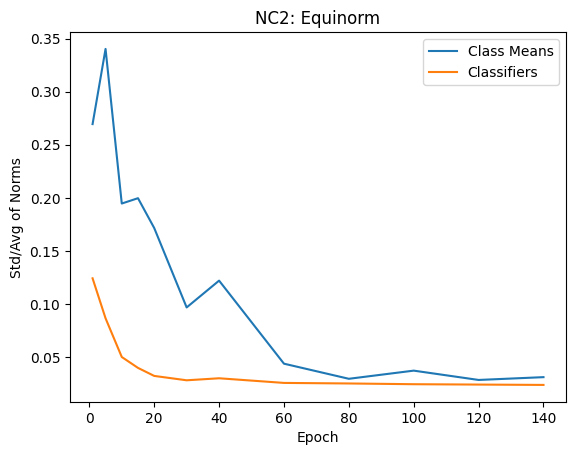

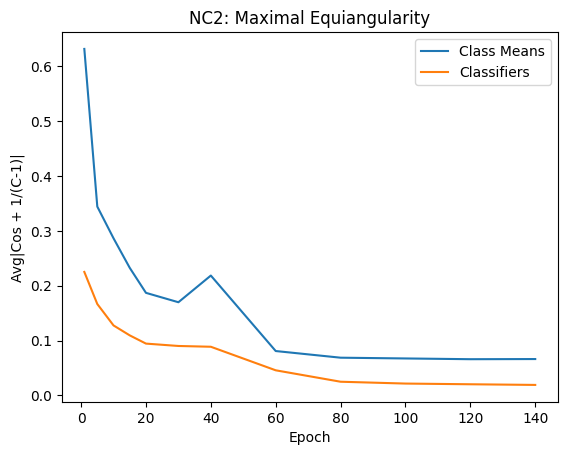

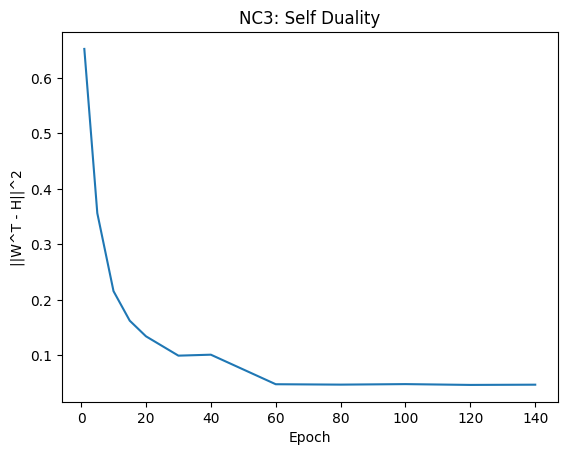

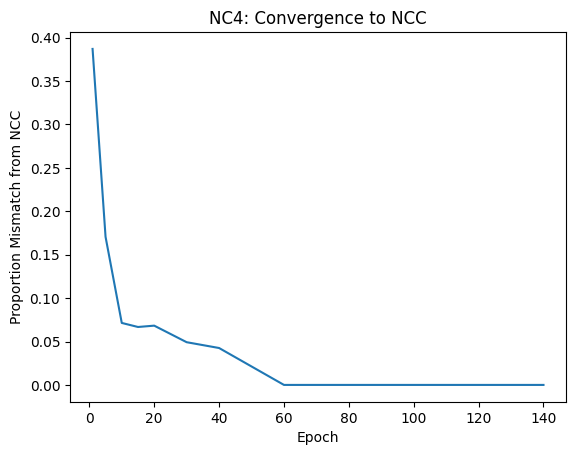

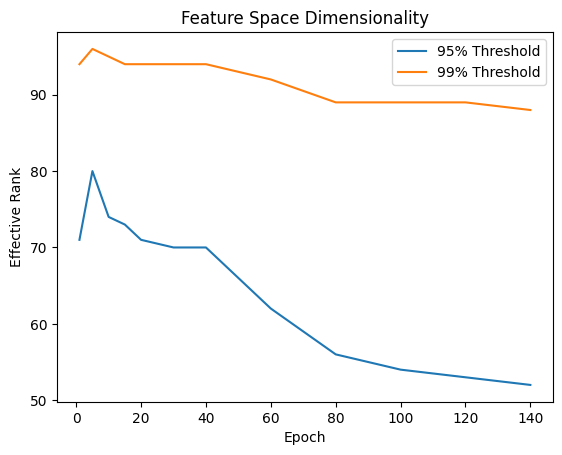

Train		Epoch: 126 [63/390 (16%)] 	Batch Loss: 0.001959 	Batch Accuracy: 1.000000:  16%|█▌        | 63/390 [13:11<1:08:27, 12.56s/it]


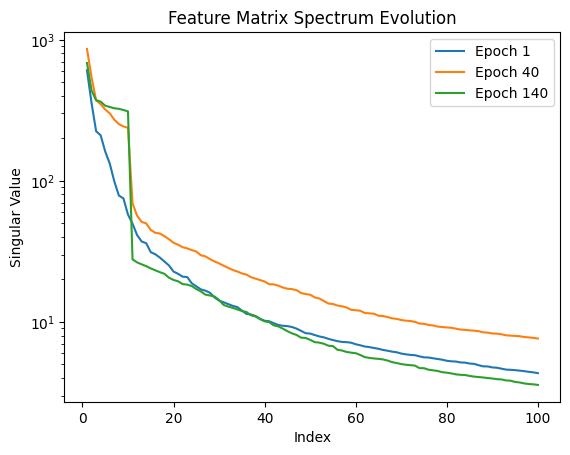

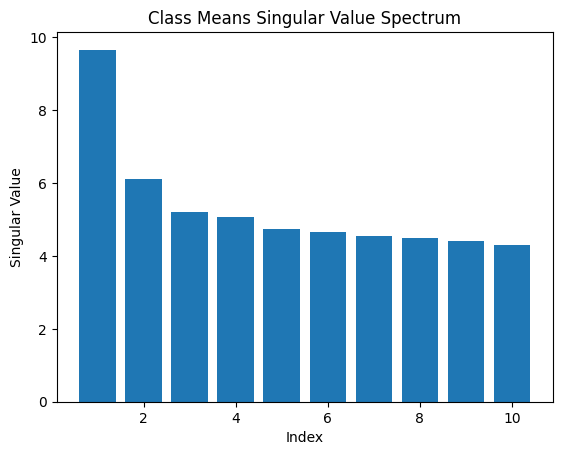

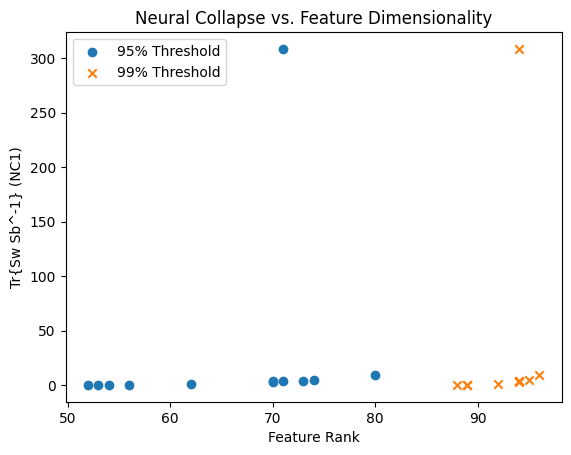

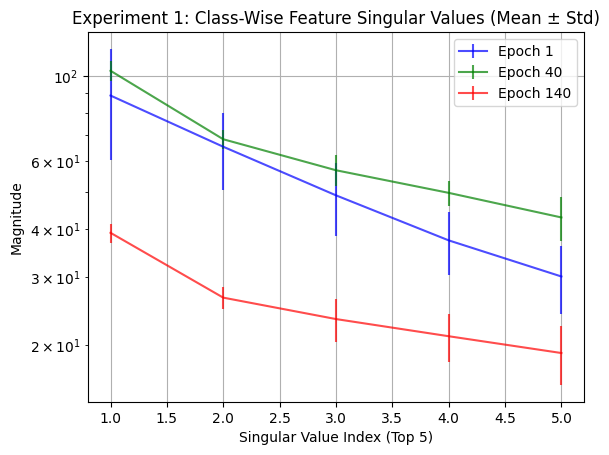

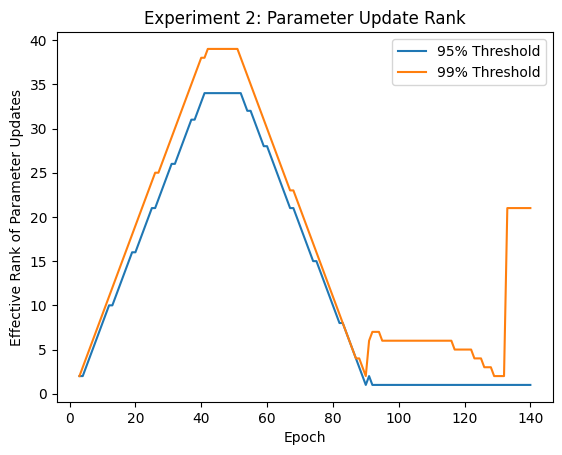

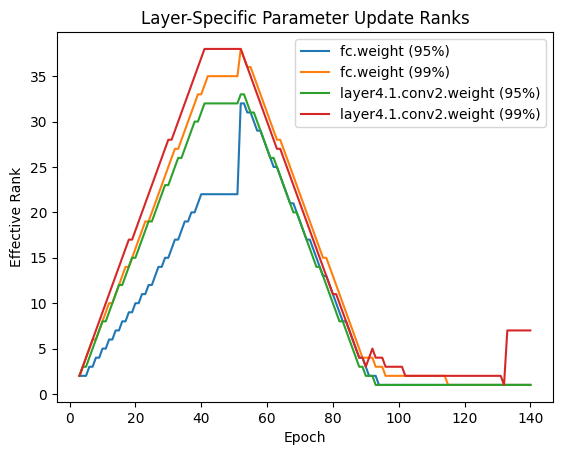

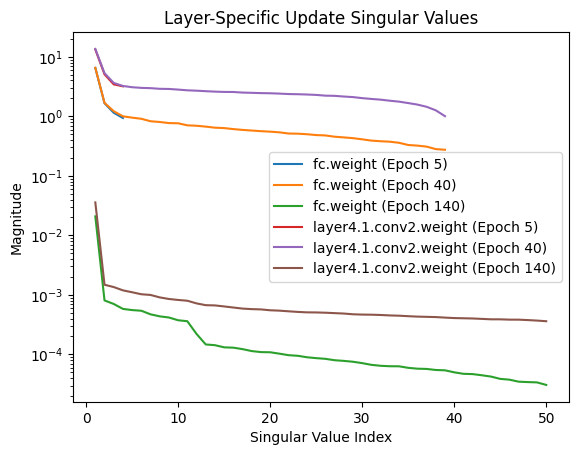

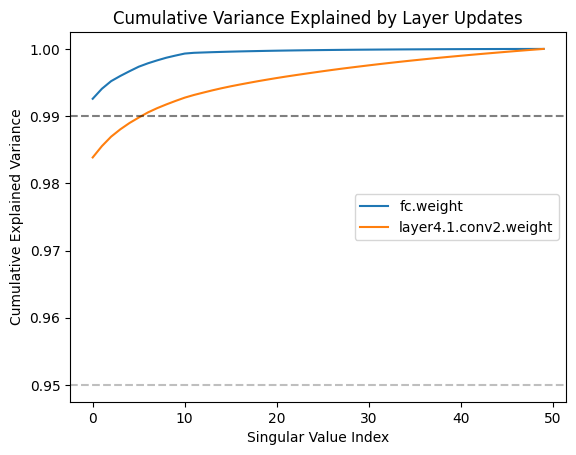

Train		Epoch: 141 [390/390 (100%)] 	Batch Loss: 0.001795 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.84it/s]
Train		Epoch: 142 [390/390 (100%)] 	Batch Loss: 0.001955 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.76it/s]
Train		Epoch: 143 [390/390 (100%)] 	Batch Loss: 0.002232 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.89it/s]
Train		Epoch: 144 [390/390 (100%)] 	Batch Loss: 0.003136 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.88it/s]
Train		Epoch: 145 [390/390 (100%)] 	Batch Loss: 0.001684 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.96it/s]
Train		Epoch: 146 [390/390 (100%)] 	Batch Loss: 0.001697 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 20.00it/s]
Train		Epoch: 147 [390/390 (100%)] 	Batch Loss: 0.001788 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.96it/s]
Train		Epoch: 148 [390/390 (100%)] 	Batch Loss: 0.002110 	Batc

Experiment data saved at epoch 150
Epoch 150: Memory usage: 3120.41 MB
Tracker deltas: 50 updates stored
GPU memory allocated: 3.48 GB
GPU memory cached: 19.11 GB
Checkpoint saved at epoch 150


Train		Epoch: 151 [390/390 (100%)] 	Batch Loss: 0.001743 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.86it/s]
Train		Epoch: 152 [390/390 (100%)] 	Batch Loss: 0.001766 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.85it/s]
Train		Epoch: 153 [390/390 (100%)] 	Batch Loss: 0.002095 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.92it/s]
Train		Epoch: 154 [390/390 (100%)] 	Batch Loss: 0.002373 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.90it/s]
Train		Epoch: 155 [390/390 (100%)] 	Batch Loss: 0.002651 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 20.03it/s]
Train		Epoch: 156 [390/390 (100%)] 	Batch Loss: 0.001638 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.81it/s]
Train		Epoch: 157 [390/390 (100%)] 	Batch Loss: 0.002748 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.86it/s]
Train		Epoch: 158 [390/390 (100%)] 	Batch Loss: 0.001809 	Batc

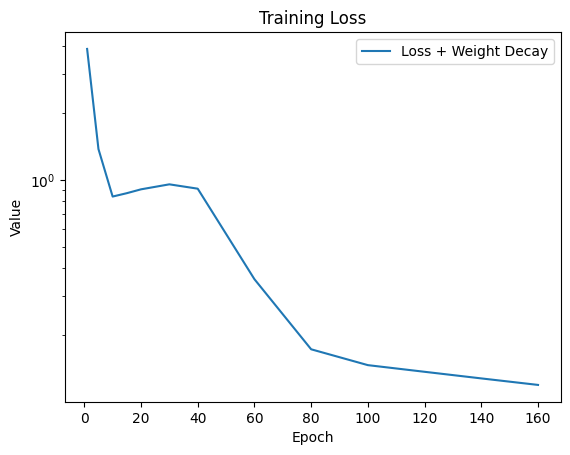

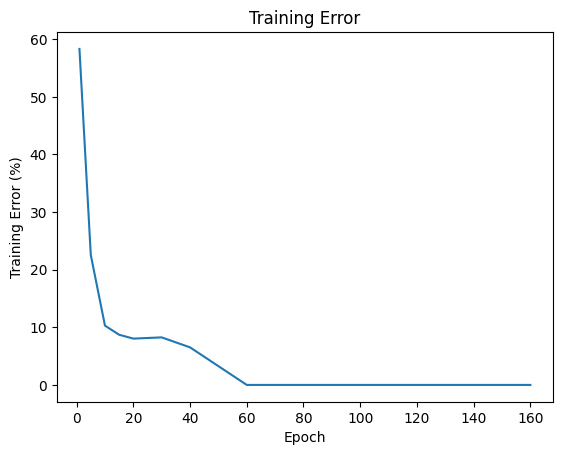

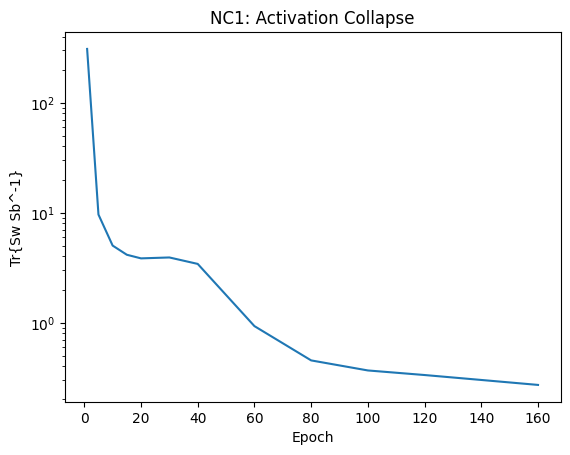

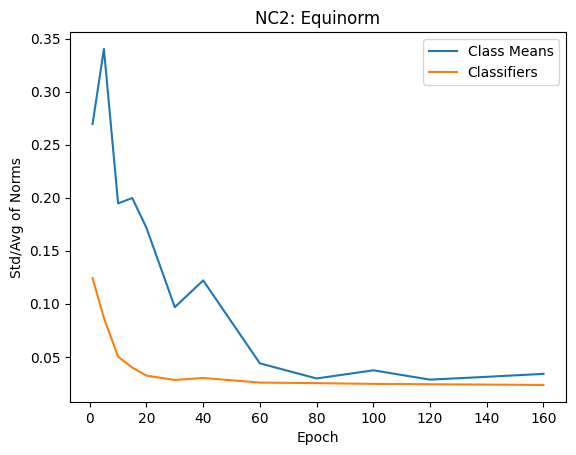

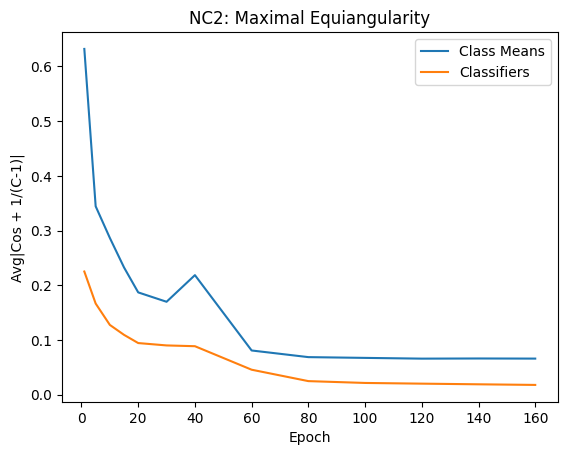

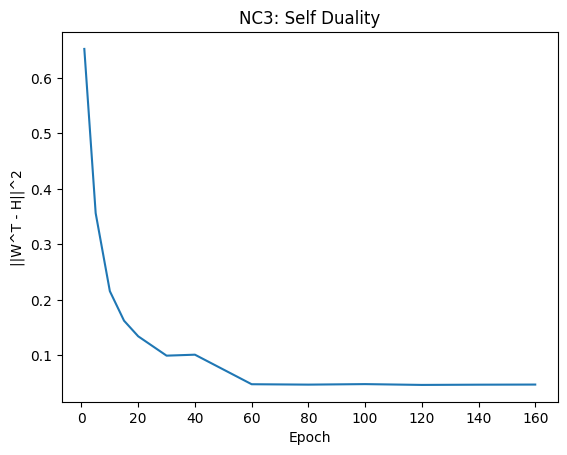

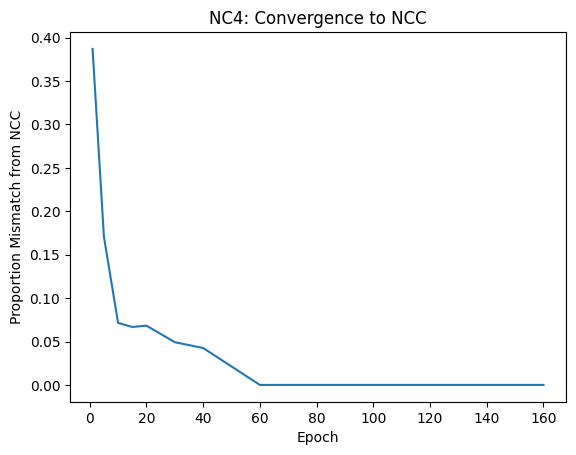

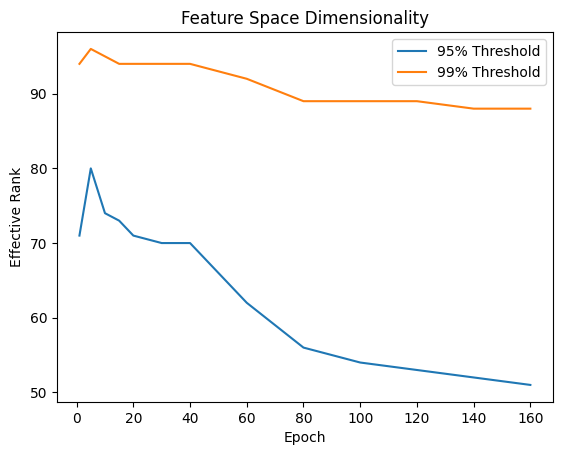

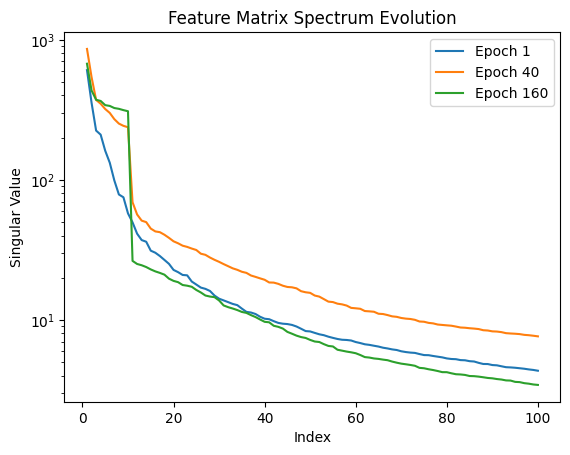

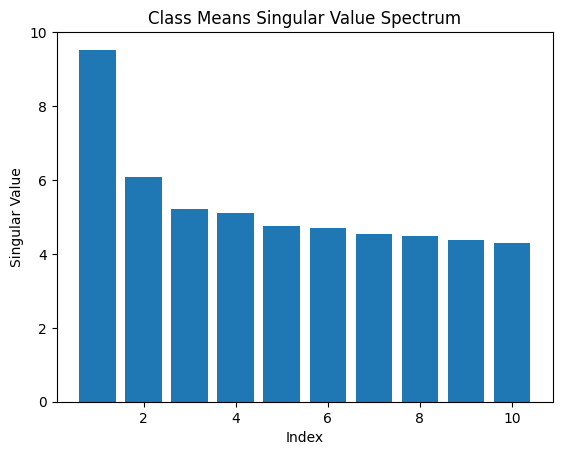

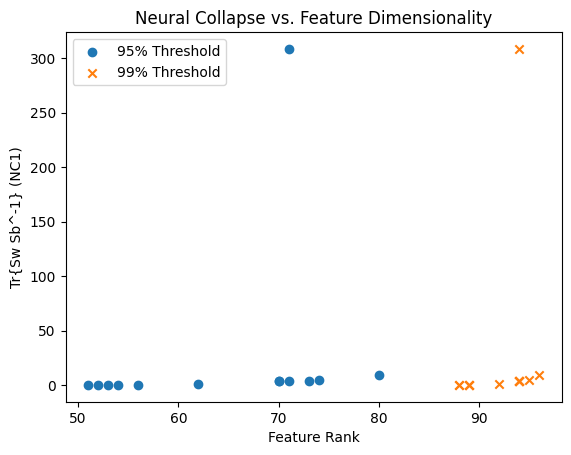

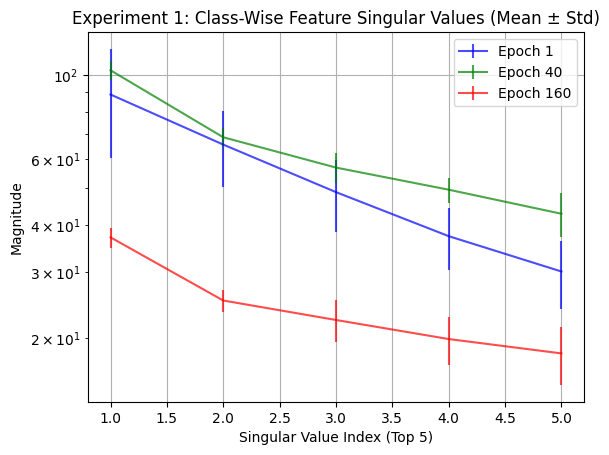

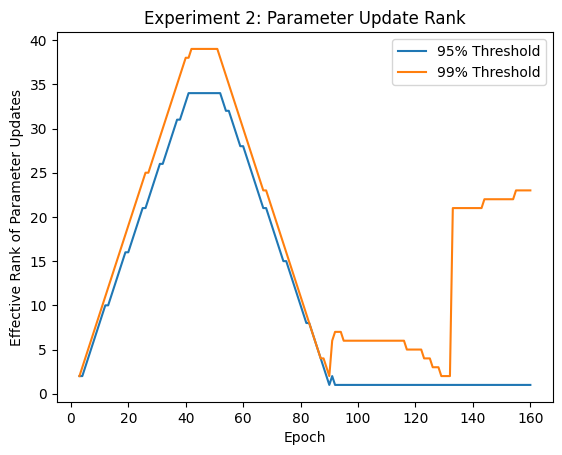

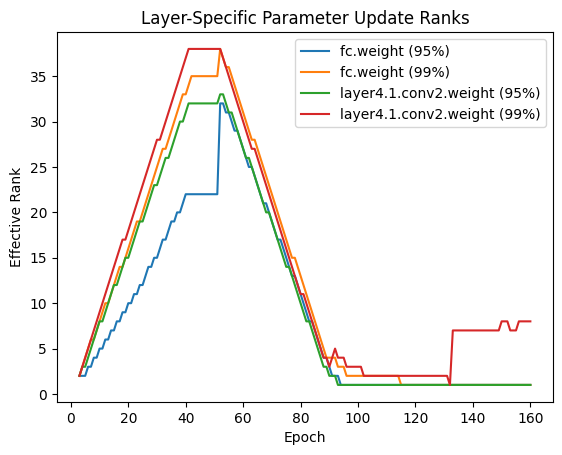

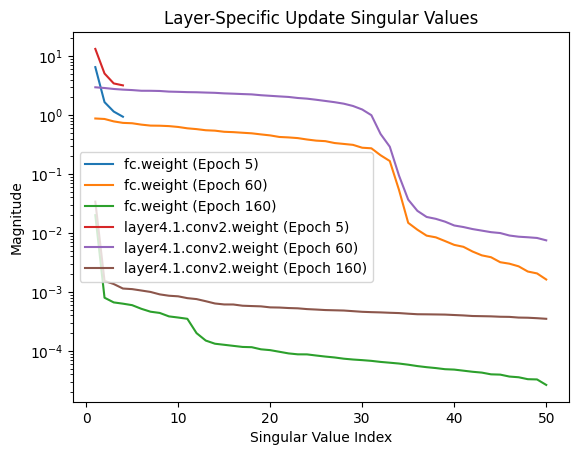

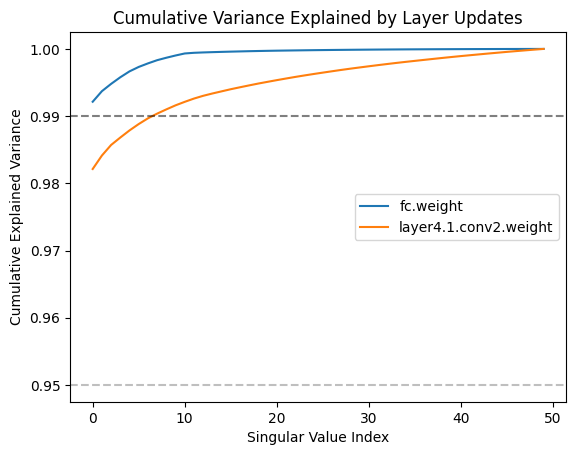

Train		Epoch: 161 [390/390 (100%)] 	Batch Loss: 0.001942 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.63it/s]
Train		Epoch: 162 [390/390 (100%)] 	Batch Loss: 0.002034 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.85it/s]
Train		Epoch: 163 [390/390 (100%)] 	Batch Loss: 0.001571 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.72it/s]
Train		Epoch: 164 [390/390 (100%)] 	Batch Loss: 0.001857 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.84it/s]
Train		Epoch: 165 [390/390 (100%)] 	Batch Loss: 0.001859 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.64it/s]
Train		Epoch: 166 [390/390 (100%)] 	Batch Loss: 0.001785 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.75it/s]
Train		Epoch: 167 [390/390 (100%)] 	Batch Loss: 0.002086 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.79it/s]
Train		Epoch: 168 [390/390 (100%)] 	Batch Loss: 0.001598 	Batc

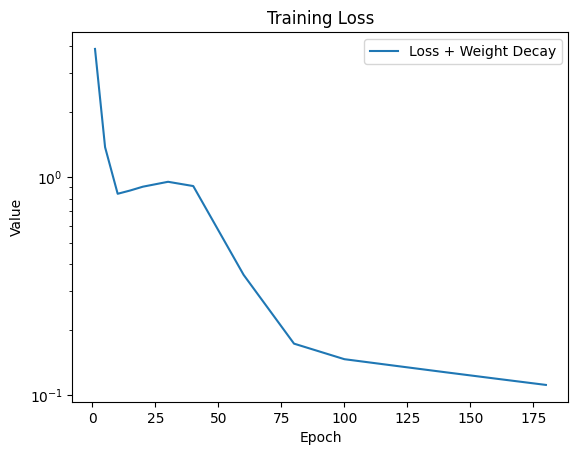

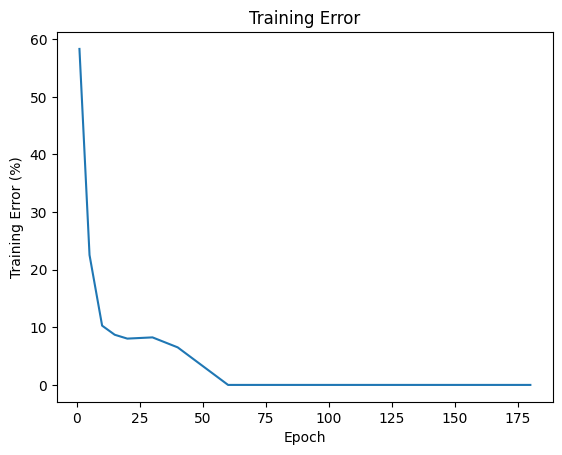

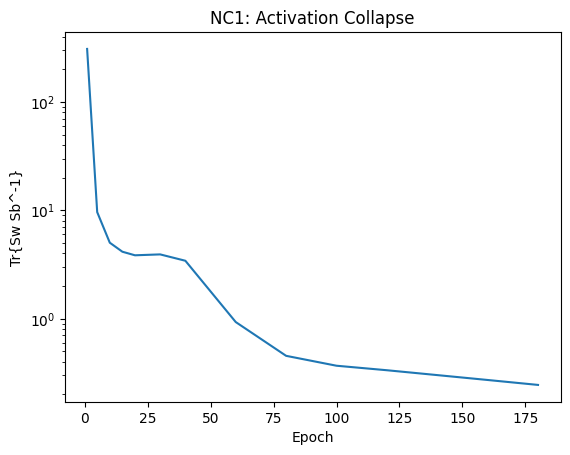

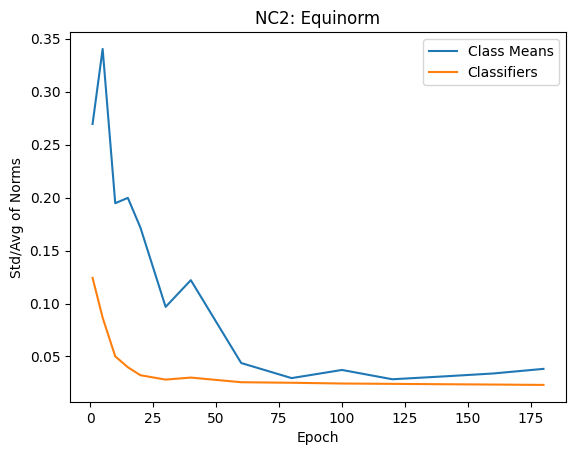

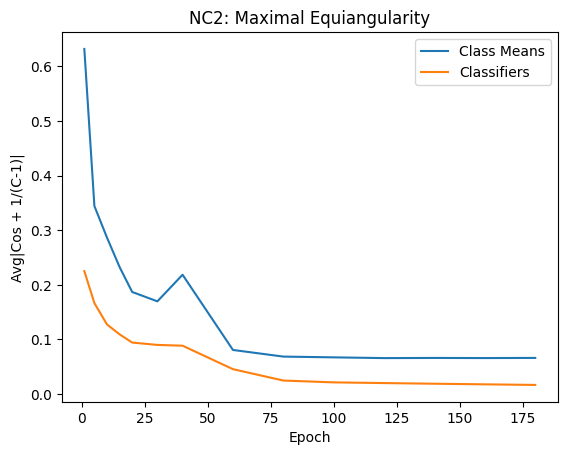

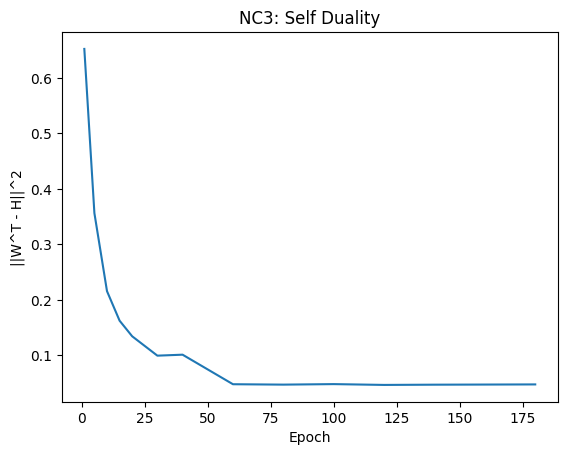

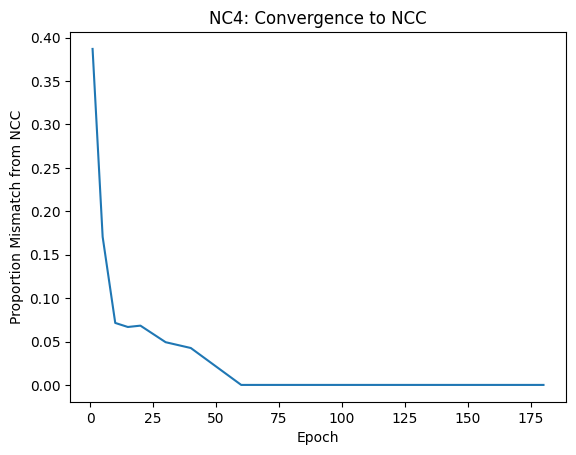

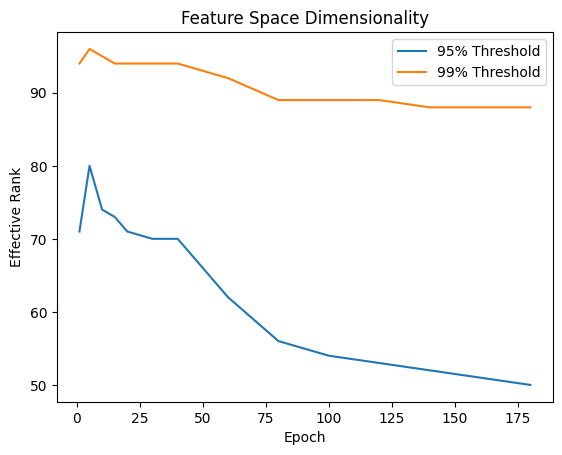

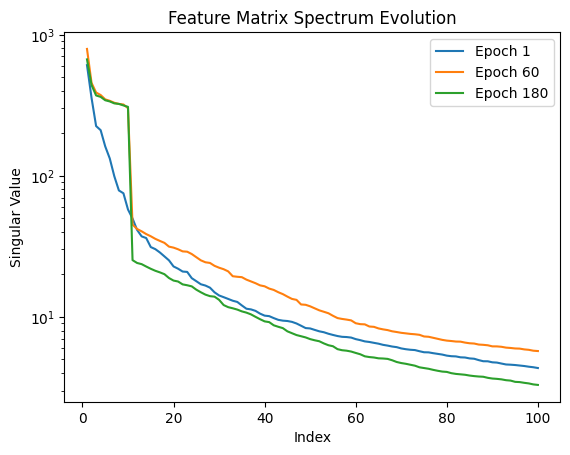

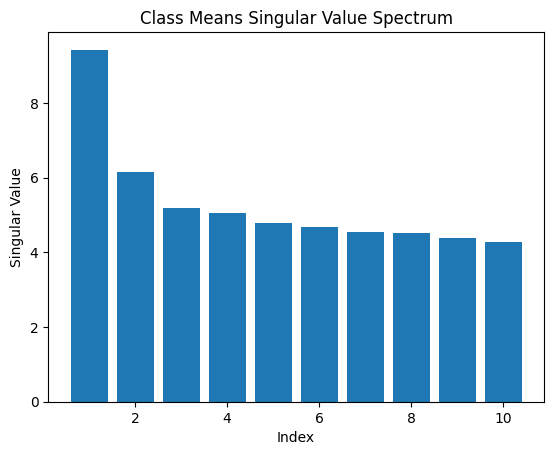

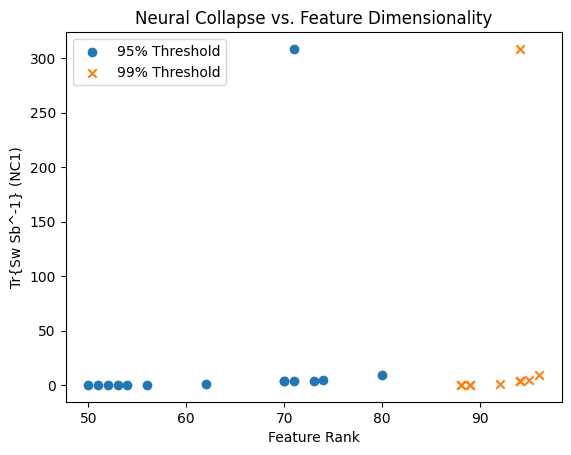

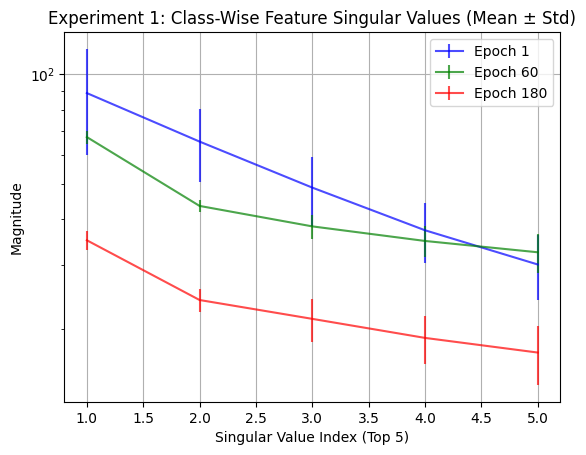

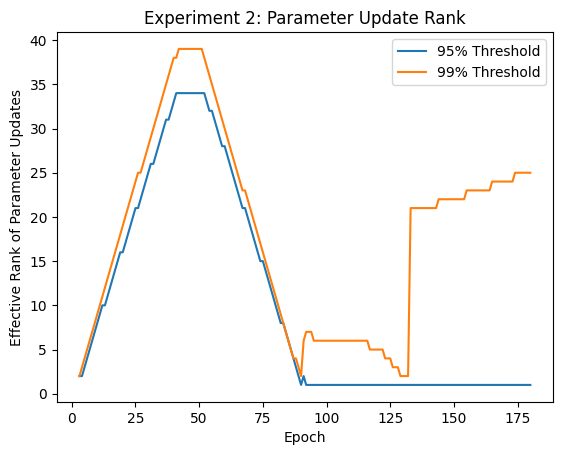

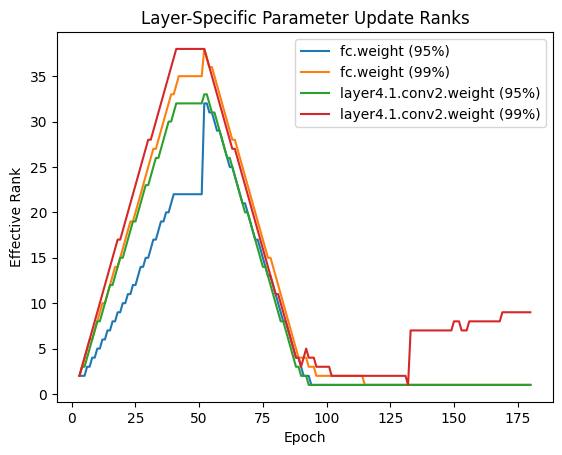

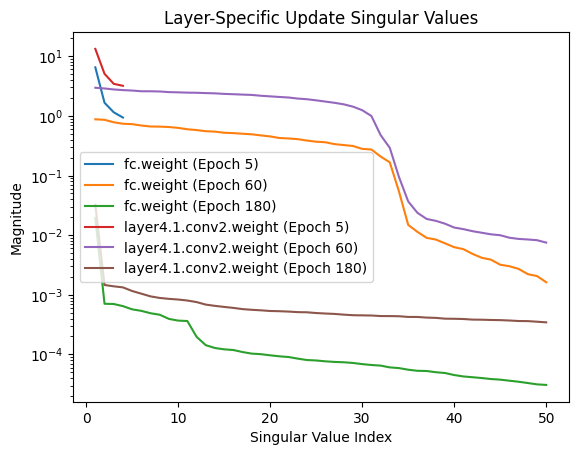

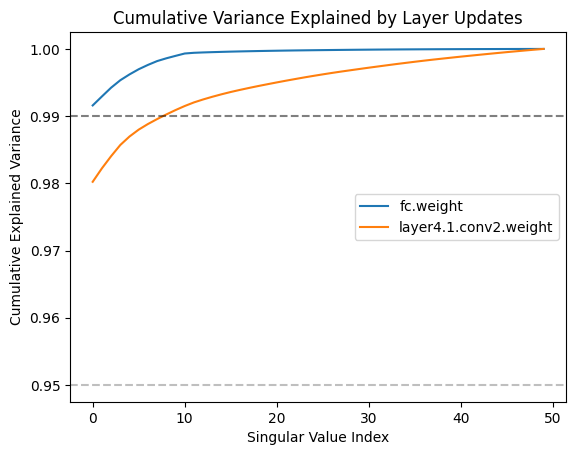

Train		Epoch: 181 [390/390 (100%)] 	Batch Loss: 0.004731 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.54it/s]
Train		Epoch: 182 [390/390 (100%)] 	Batch Loss: 0.002135 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.43it/s]
Train		Epoch: 183 [390/390 (100%)] 	Batch Loss: 0.001664 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.39it/s]
Train		Epoch: 184 [390/390 (100%)] 	Batch Loss: 0.001931 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.39it/s]
Train		Epoch: 185 [390/390 (100%)] 	Batch Loss: 0.001731 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.38it/s]
Train		Epoch: 186 [390/390 (100%)] 	Batch Loss: 0.001648 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.47it/s]
Train		Epoch: 187 [390/390 (100%)] 	Batch Loss: 0.001955 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.42it/s]
Train		Epoch: 188 [390/390 (100%)] 	Batch Loss: 0.002136 	Batc

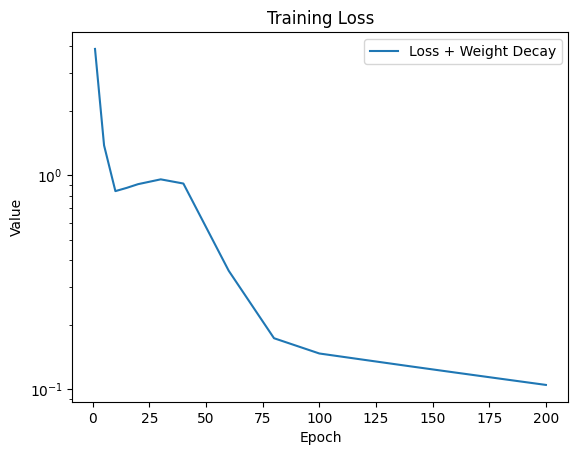

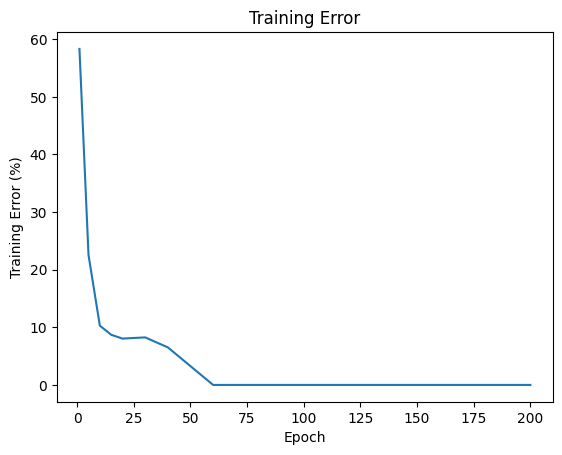

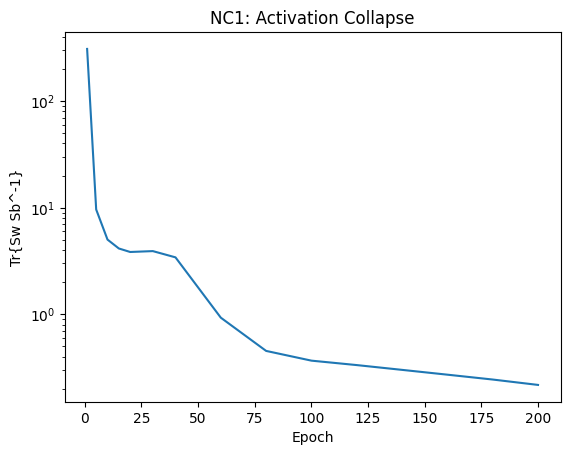

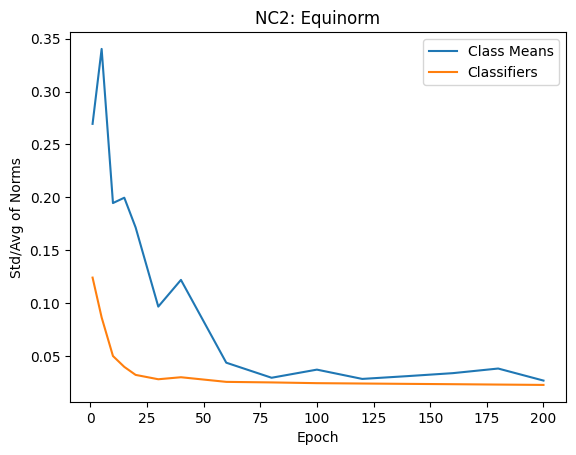

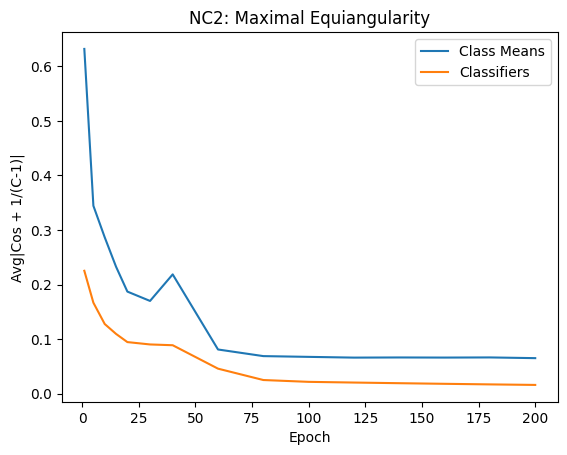

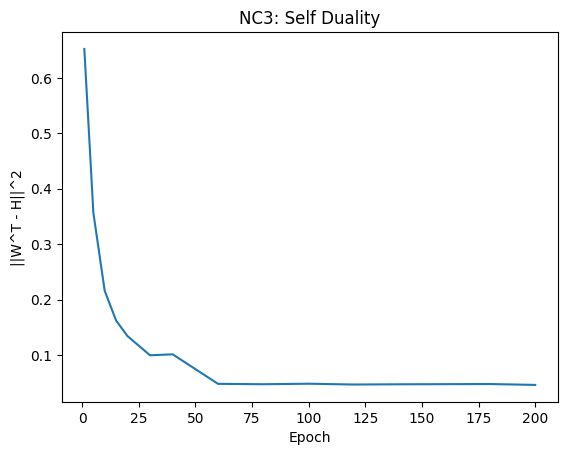

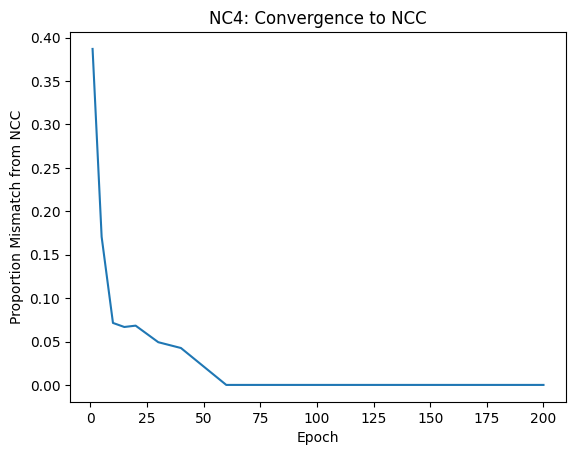

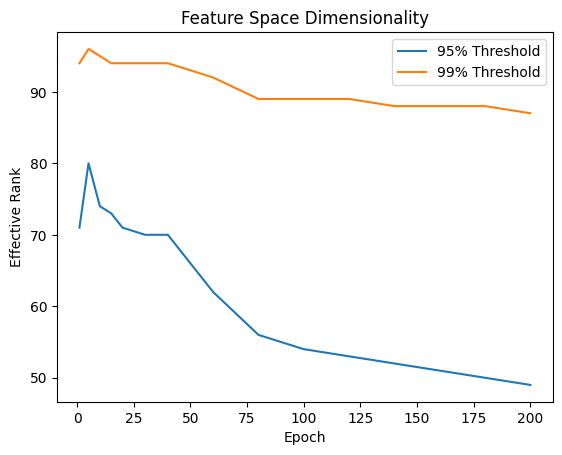

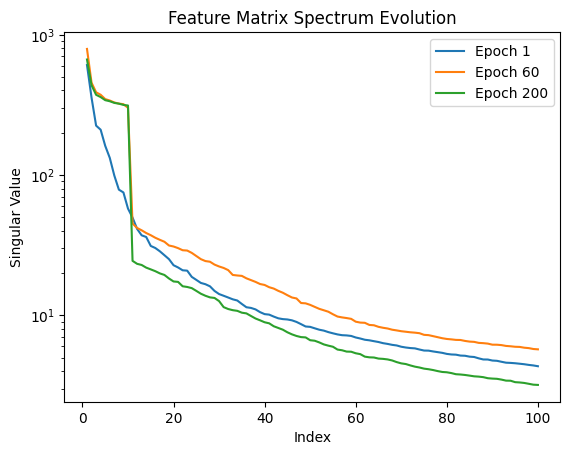

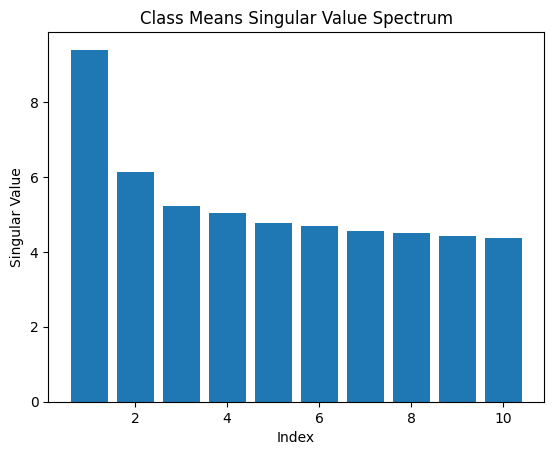

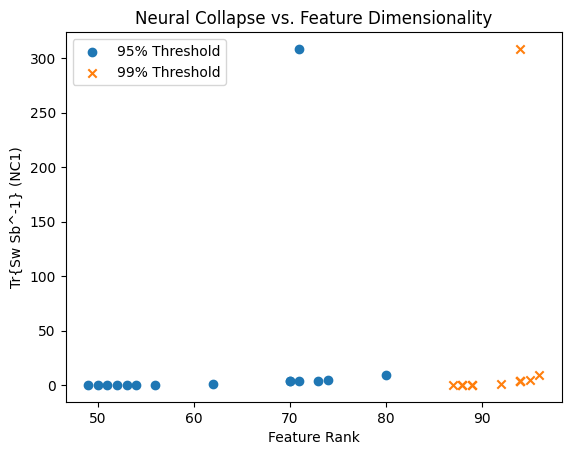

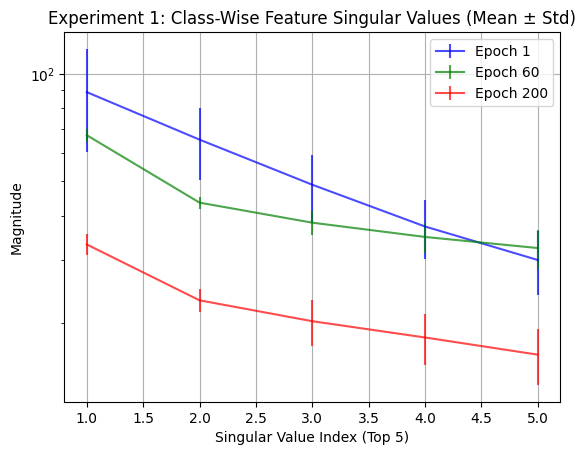

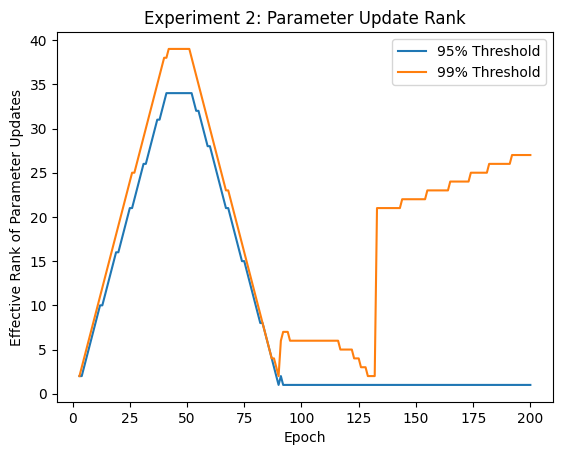

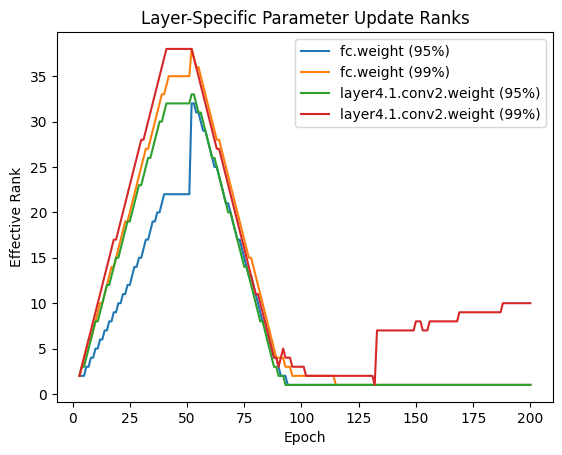

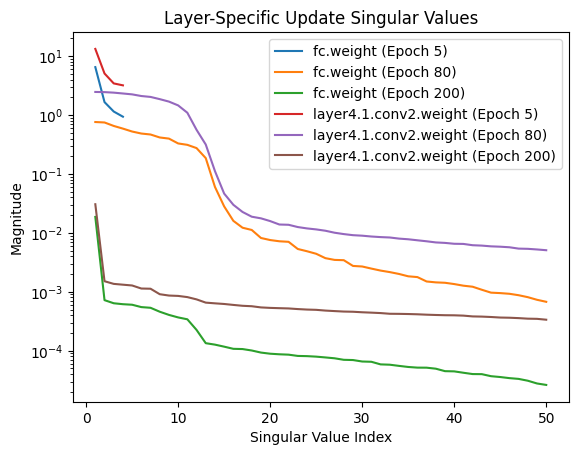

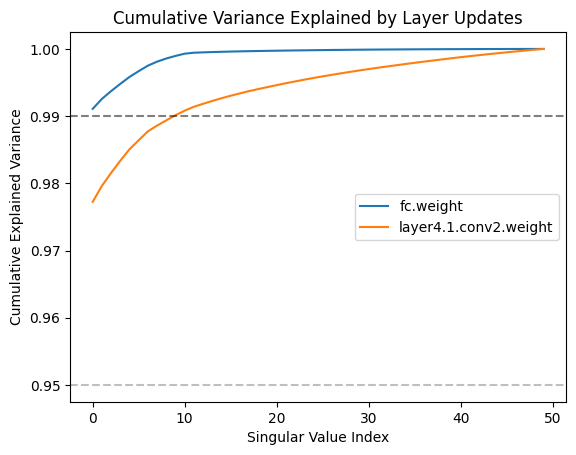

Experiment data saved at epoch 200
Epoch 200: Memory usage: 3123.07 MB
Tracker deltas: 50 updates stored
GPU memory allocated: 4.08 GB
GPU memory cached: 16.10 GB
Checkpoint saved at epoch 200


Train		Epoch: 201 [390/390 (100%)] 	Batch Loss: 0.003095 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.41it/s]
Train		Epoch: 202 [390/390 (100%)] 	Batch Loss: 0.001456 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.44it/s]
Train		Epoch: 203 [390/390 (100%)] 	Batch Loss: 0.001559 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.68it/s]
Train		Epoch: 204 [390/390 (100%)] 	Batch Loss: 0.001348 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.61it/s]
Train		Epoch: 205 [390/390 (100%)] 	Batch Loss: 0.001480 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.63it/s]
Train		Epoch: 206 [390/390 (100%)] 	Batch Loss: 0.002384 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.66it/s]
Train		Epoch: 207 [390/390 (100%)] 	Batch Loss: 0.002018 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.72it/s]
Train		Epoch: 208 [390/390 (100%)] 	Batch Loss: 0.002371 	Batc

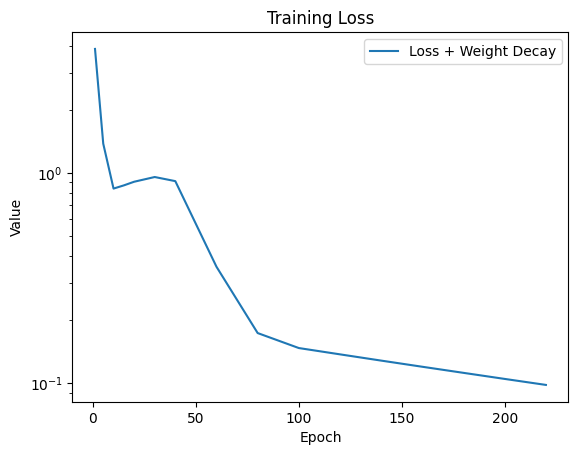

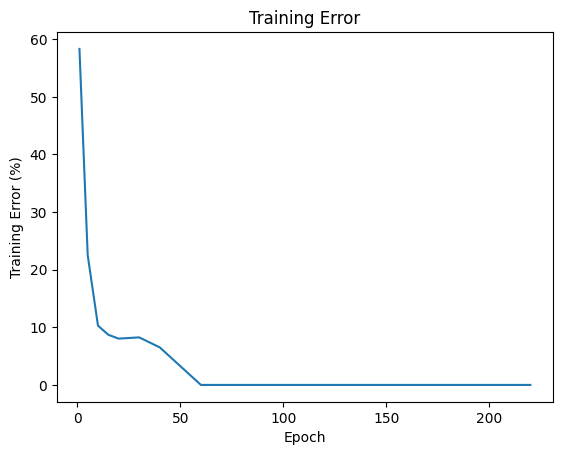

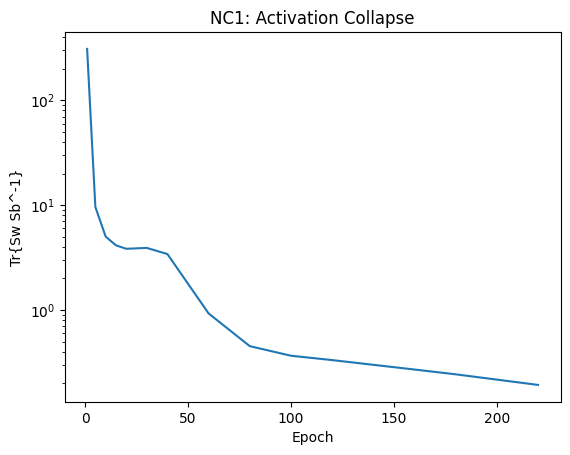

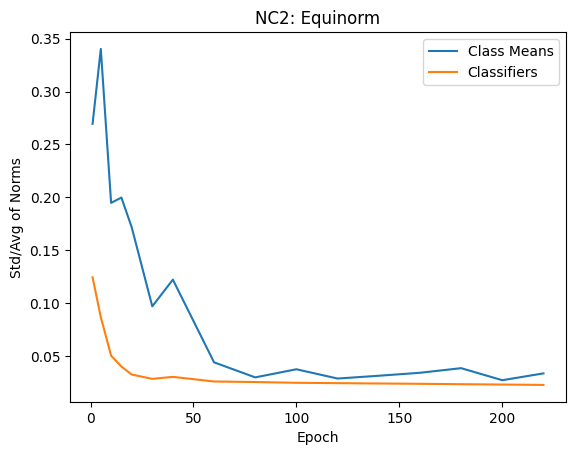

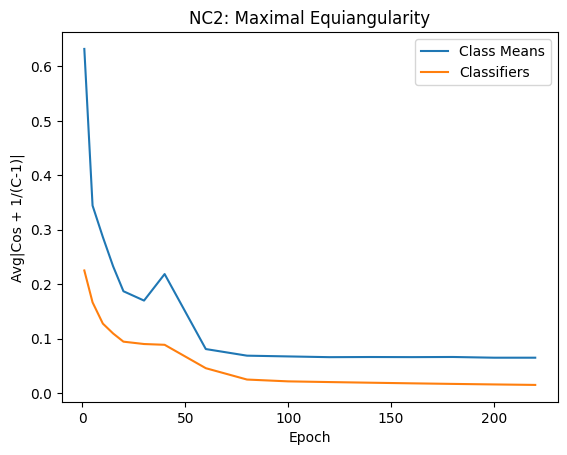

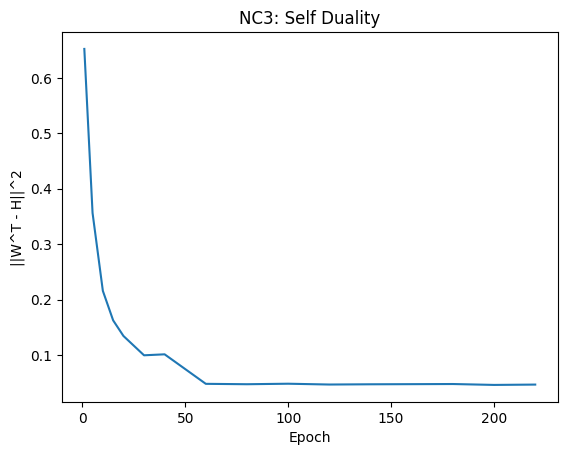

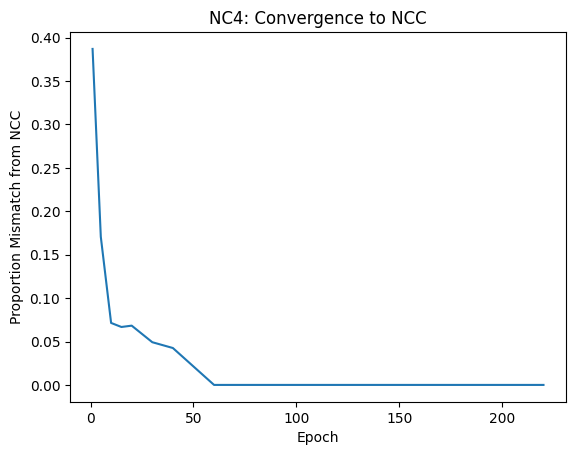

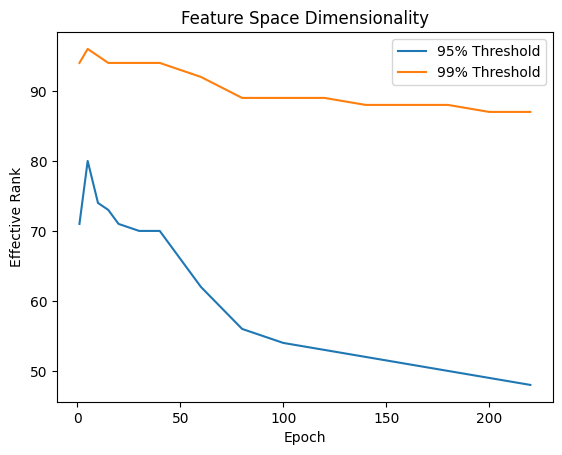

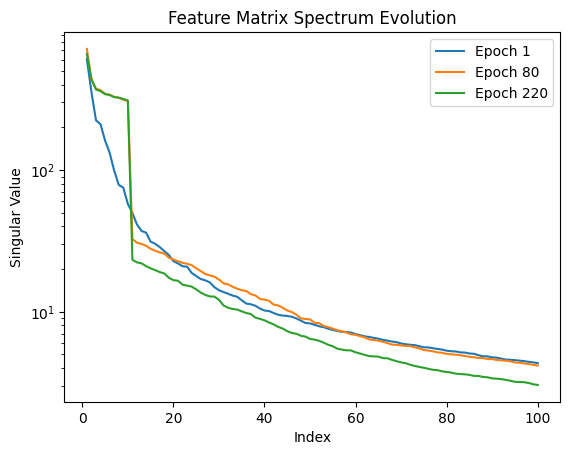

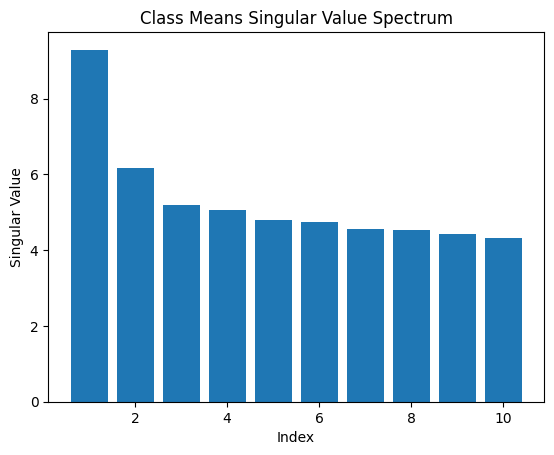

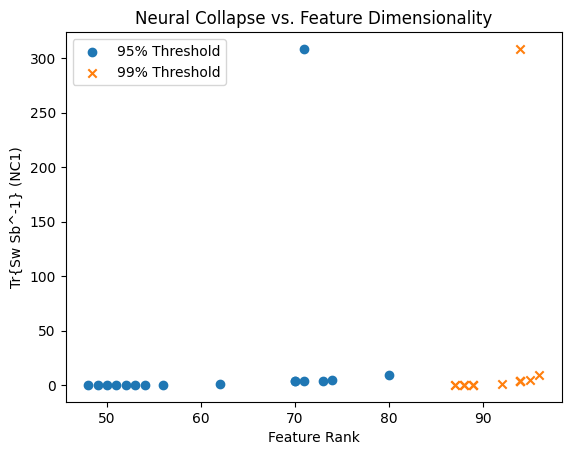

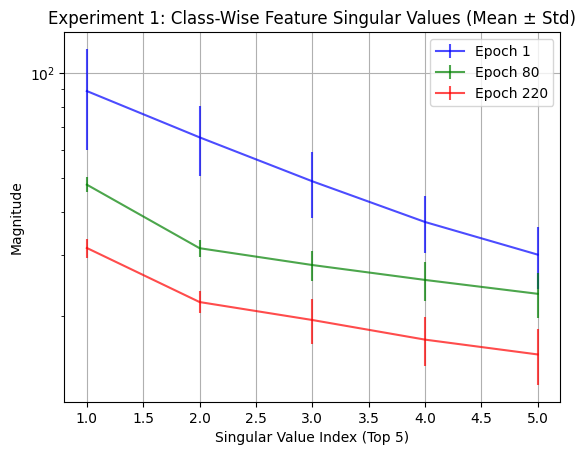

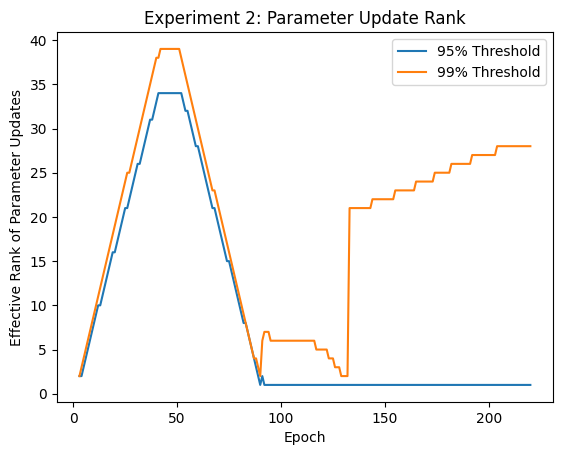

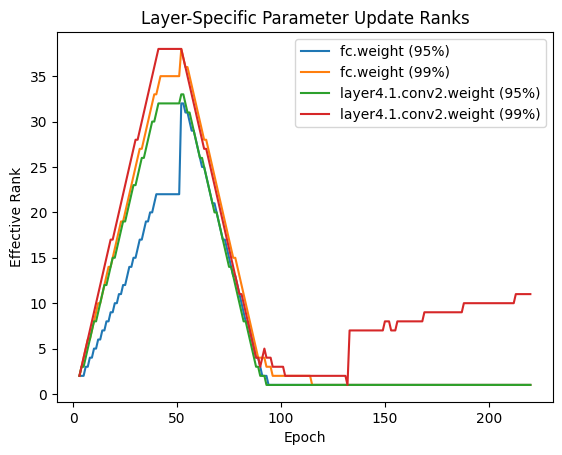

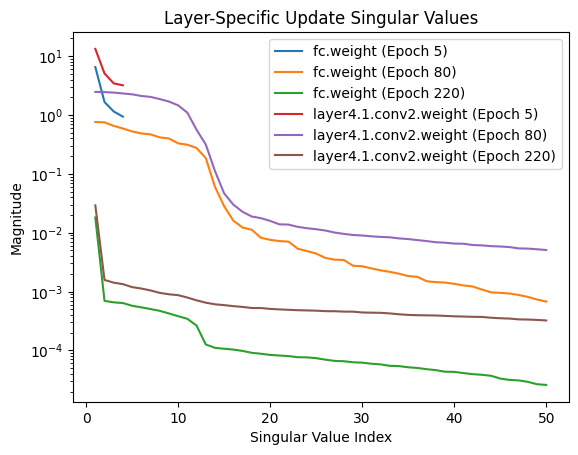

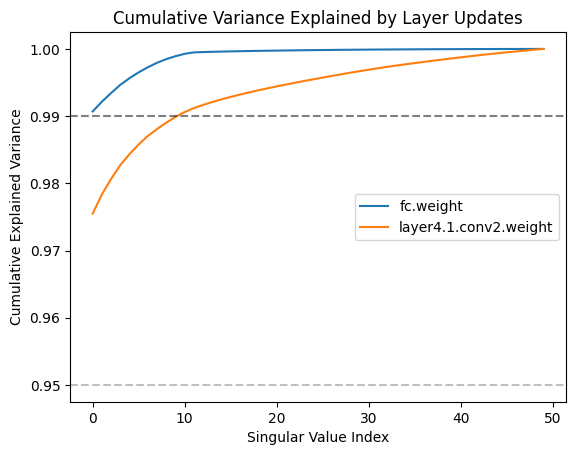

Train		Epoch: 221 [390/390 (100%)] 	Batch Loss: 0.001520 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.49it/s]
Train		Epoch: 222 [390/390 (100%)] 	Batch Loss: 0.001679 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.82it/s]
Train		Epoch: 223 [390/390 (100%)] 	Batch Loss: 0.002508 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.71it/s]
Train		Epoch: 224 [390/390 (100%)] 	Batch Loss: 0.003868 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.65it/s]
Train		Epoch: 225 [390/390 (100%)] 	Batch Loss: 0.002075 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.53it/s]
Train		Epoch: 226 [390/390 (100%)] 	Batch Loss: 0.001799 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:20<00:00, 19.47it/s]
Train		Epoch: 227 [390/390 (100%)] 	Batch Loss: 0.001554 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.55it/s]
Train		Epoch: 228 [390/390 (100%)] 	Batch Loss: 0.001347 	Batc

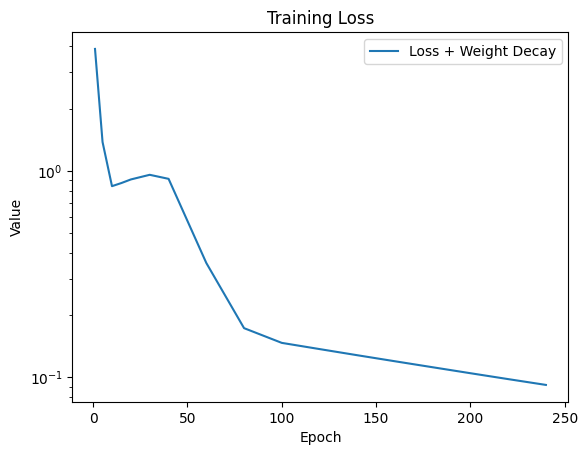

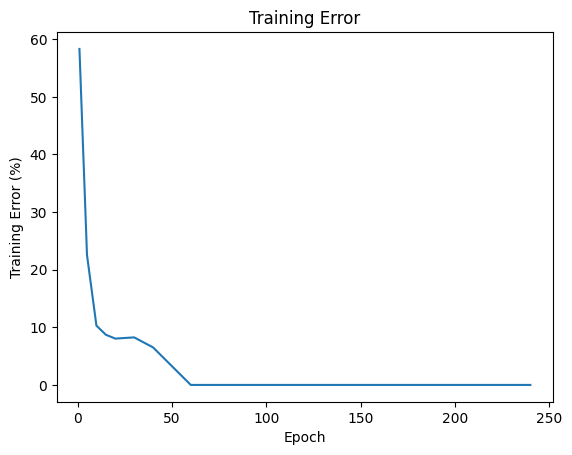

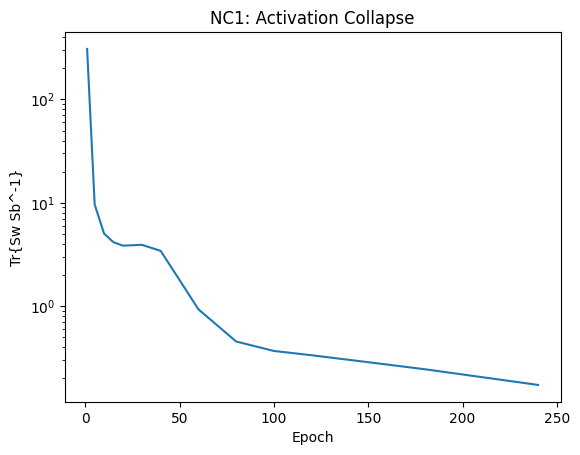

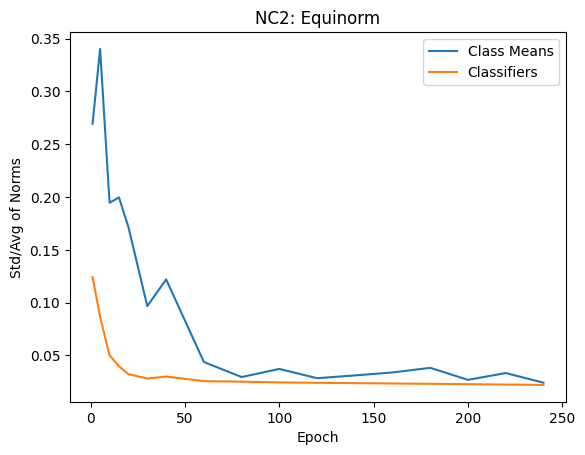

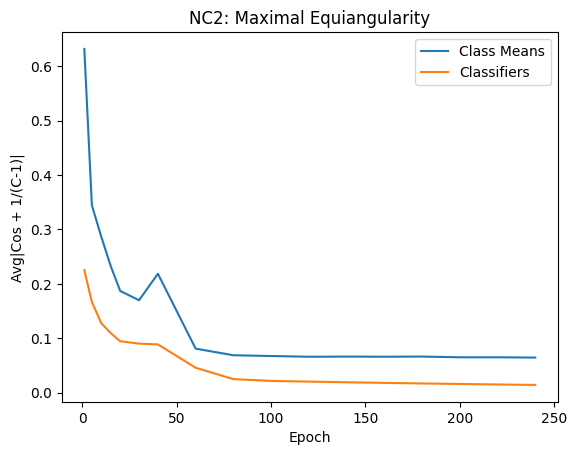

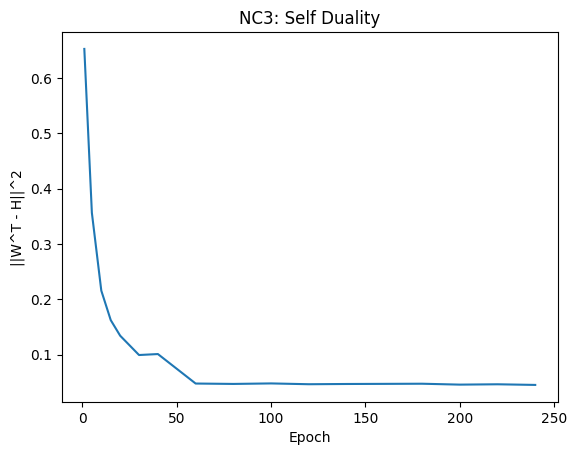

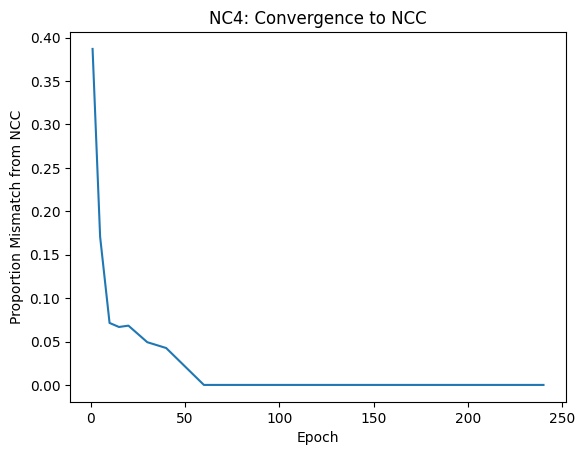

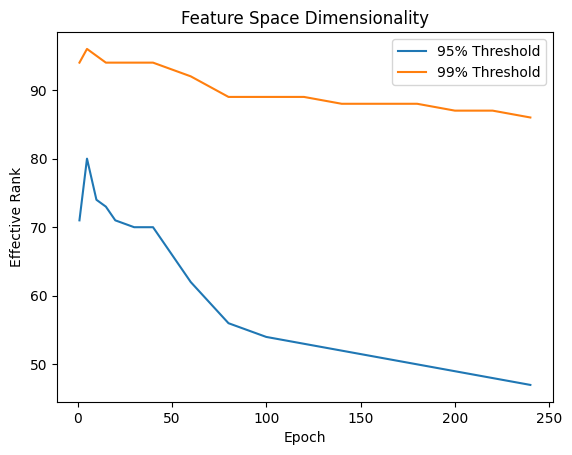

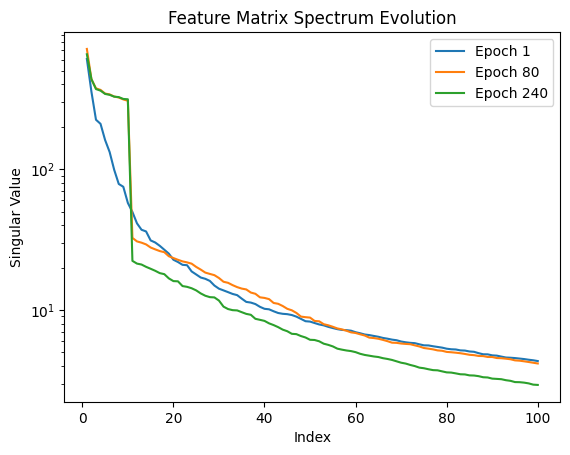

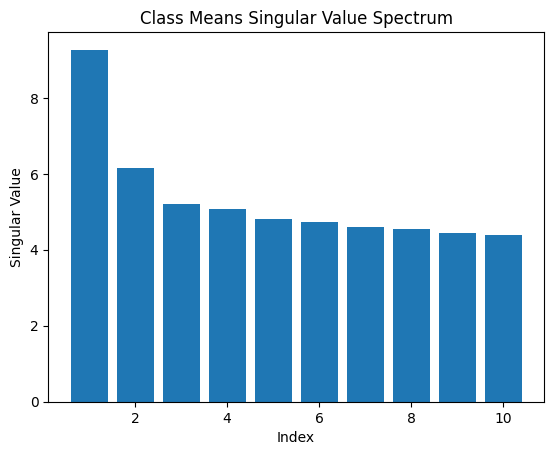

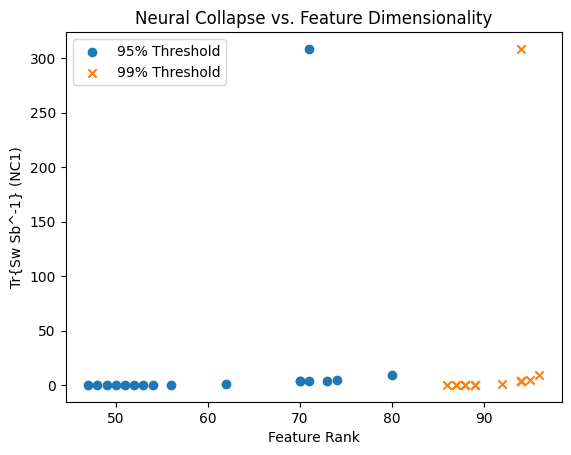

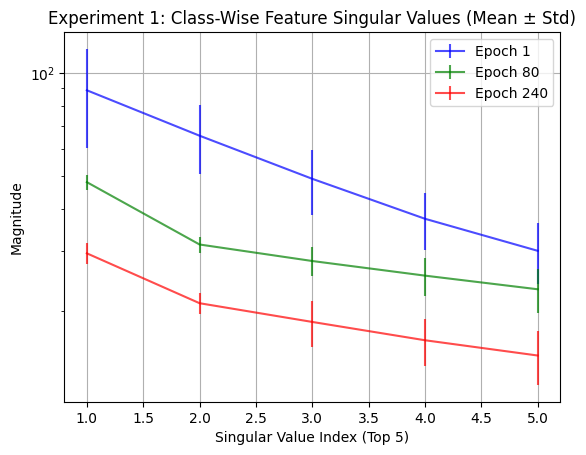

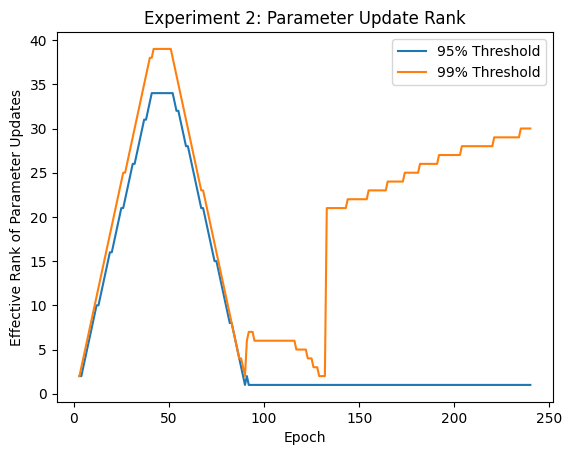

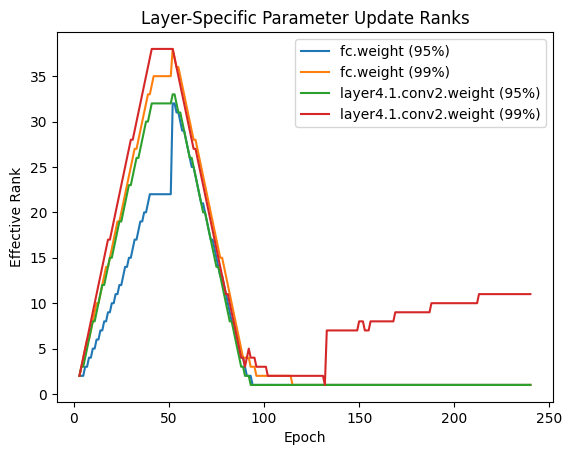

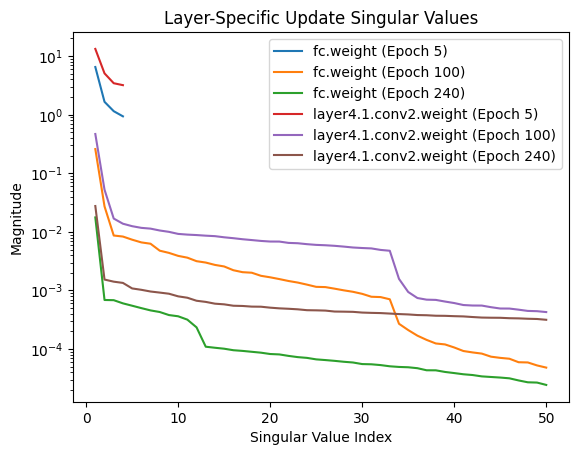

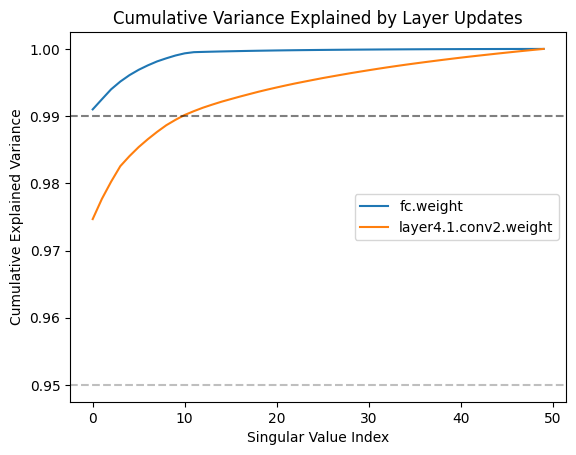

Train		Epoch: 241 [390/390 (100%)] 	Batch Loss: 0.001719 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.69it/s]
Train		Epoch: 242 [390/390 (100%)] 	Batch Loss: 0.001863 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.64it/s]
Train		Epoch: 243 [390/390 (100%)] 	Batch Loss: 0.001836 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.71it/s]
Train		Epoch: 244 [390/390 (100%)] 	Batch Loss: 0.001707 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.91it/s]
Train		Epoch: 245 [390/390 (100%)] 	Batch Loss: 0.002182 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.88it/s]
Train		Epoch: 246 [390/390 (100%)] 	Batch Loss: 0.001549 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.96it/s]
Train		Epoch: 247 [390/390 (100%)] 	Batch Loss: 0.002313 	Batch Accuracy: 1.000000: 100%|██████████| 390/390 [00:19<00:00, 19.75it/s]
Train		Epoch: 248 [390/390 (100%)] 	Batch Loss: 0.001668 	Batc

Experiment data saved at epoch 250
Epoch 250: Memory usage: 3124.28 MB
Tracker deltas: 50 updates stored
GPU memory allocated: 3.48 GB
GPU memory cached: 15.92 GB
Checkpoint saved at epoch 250
Successfully saved large checkpoint to Drive.


In [24]:
model = models.resnet18(pretrained=False, num_classes=C)
model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
model.maxpool = nn.Identity()
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                ])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True, drop_last=True)

if loss_name == 'CrossEntropyLoss':
  criterion = nn.CrossEntropyLoss()
  criterion_summed = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)

if checkpoint:
    print("Loading checkpoint...")
    checkpoint = torch.load(data_path + 'checkpoint.pth', map_location=device, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])

    graphs = checkpoint['graphs']
    tracker = checkpoint['tracker']
    cur_epochs = checkpoint['cur_epochs']
    start_epoch = checkpoint['epoch'] + 1

    # ## Debug: check, force tensors to GPU
    # print("Checkpoint loaded, analyzing tensor devices...")
    # # Check devices in tracker
    # if hasattr(tracker, 'global_deltas'):
    #     devices = set()
    #     for i, delta in enumerate(tracker.global_deltas):
    #         devices.add(str(delta.device))
    #         print(f"Delta {i}: shape={delta.shape}, device={delta.device}, norm={torch.norm(delta).item()}")
    #     print(f"Found tensors on devices: {devices}")

    # # Check current model device
    # model_device = next(model.parameters()).device
    # print(f"Model is on device: {model_device}")

    # # Force move all tensors in tracker to model device
    # device = next(model.parameters()).device
    # print(f"Moving all tensors to {device}")

    # # Move global deltas
    # if hasattr(tracker, 'global_deltas'):
    #     tracker.global_deltas = [delta.to(device) for delta in tracker.global_deltas]
    #     print(f"Moved {len(tracker.global_deltas)} global deltas to {device}")

    # # Move layer deltas
    # if hasattr(tracker, 'layer_deltas'):
    #     for layer_name in tracker.layer_deltas:
    #         tracker.layer_deltas[layer_name] = [delta.to(device) for delta in tracker.layer_deltas[layer_name]]
    #     print(f"Moved layer deltas for {len(tracker.layer_deltas)} layers to {device}")

    # # Move previous weights
    # if hasattr(tracker, 'prev_weights'):
    #     tracker.prev_weights = {k: v.to(device) for k, v in tracker.prev_weights.items()}
    #     print("Moved previous weights to {device}")


else:
    tracker = UpdateTracker(model)
    graphs = Graphs()
    cur_epochs = []
    start_epoch = 1


for epoch in range(start_epoch, epochs + 1):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()


    # === Experiment 2 data collection ===
    update_epochs = list(range(1, epoch + 1)) # used for graphs, data saving
    global_rank, global_sv, layer_ranks, layer_svs = tracker.compute_update_rank(model)
    graphs.update_ranks.append(global_rank)
    for layer_name in tracked_layers:
        graphs.layer_update_ranks[layer_name].append(layer_ranks[layer_name])

    # store spectra only for analysis epochs
    if epoch in analysis_epochs:
        graphs.update_spectra.append(global_sv)
        for layer_name in tracked_layers:
            graphs.layer_singular_values[layer_name].append(layer_svs[layer_name])
    else:
        # Store None as placeholder to maintain index alignment with epoch numbers
        graphs.update_spectra.append(None)
        for layer_name in tracked_layers:
            graphs.layer_singular_values[layer_name].append(None)
            # graphs.layer_update_ranks[layer_name].append({'0.95': np.nan, '0.99': np.nan})


    if epoch in analysis_epochs:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)

        # === Graphs ===
        ## Experiment 0: NC Figures
        plt.figure(1)
        plt.semilogy(cur_epochs, graphs.reg_loss)
        plt.legend(['Loss + Weight Decay'])
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Training Loss')

        plt.figure(2)
        plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
        plt.xlabel('Epoch')
        plt.ylabel('Training Error (%)')
        plt.title('Training Error')

        plt.figure(3)
        plt.semilogy(cur_epochs, graphs.Sw_invSb)
        plt.xlabel('Epoch')
        plt.ylabel('Tr{Sw Sb^-1}')
        plt.title('NC1: Activation Collapse')

        plt.figure(4)
        plt.plot(cur_epochs, graphs.norm_M_CoV)
        plt.plot(cur_epochs, graphs.norm_W_CoV)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Std/Avg of Norms')
        plt.title('NC2: Equinorm')

        plt.figure(5)
        plt.plot(cur_epochs, graphs.cos_M)
        plt.plot(cur_epochs, graphs.cos_W)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Avg|Cos + 1/(C-1)|')
        plt.title('NC2: Maximal Equiangularity')

        plt.figure(6)
        plt.plot(cur_epochs,graphs.W_M_dist)
        plt.xlabel('Epoch')
        plt.ylabel('||W^T - H||^2')
        plt.title('NC3: Self Duality')

        plt.figure(7)
        plt.plot(cur_epochs,graphs.NCC_mismatch)
        plt.xlabel('Epoch')
        plt.ylabel('Proportion Mismatch from NCC')
        plt.title('NC4: Convergence to NCC')

        ## Experiment 1 Figures
        plt.figure(8)
        plt.plot(cur_epochs, [x['0.95'] for x in graphs.feature_rank], label='95% Threshold')
        plt.plot(cur_epochs, [x['0.99'] for x in graphs.feature_rank], label='99% Threshold')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.title('Feature Space Dimensionality')

        plt.figure(9)
        # Plot singular value spectra for selected epochs
        selected_epochs = [0, len(cur_epochs)//2, -1]  # First, middle, last
        for i, epoch_idx in enumerate(selected_epochs):
            if epoch_idx < len(graphs.singular_values):
                sv = graphs.singular_values[epoch_idx]
                plt.semilogy(range(1, len(sv)+1), sv, label=f'Epoch {cur_epochs[epoch_idx]}')
        plt.xlabel('Index')
        plt.ylabel('Singular Value')
        plt.title('Feature Matrix Spectrum Evolution')
        plt.legend()

        plt.figure(10)
        # Plot class means singular values for the last epoch
        if len(graphs.mean_singular_values) > 0:
            sv_means = graphs.mean_singular_values[-1]
            plt.bar(range(1, len(sv_means)+1), sv_means)
            plt.xlabel('Index')
            plt.ylabel('Singular Value')
            plt.title('Class Means Singular Value Spectrum')

        # Correlation between NC metrics and feature rank
        plt.figure(11)
        plt.scatter([x['0.95'] for x in graphs.feature_rank], graphs.Sw_invSb,
            label='95% Threshold')
        plt.scatter([x['0.99'] for x in graphs.feature_rank], graphs.Sw_invSb,
                    label='99% Threshold', marker='x')
        plt.legend()
        plt.xlabel('Feature Rank')
        plt.ylabel('Tr{Sw Sb^-1} (NC1)')
        plt.title('Neural Collapse vs. Feature Dimensionality')

        plt.figure(12)
        selected_epochs = [0, len(cur_epochs)//2, -1]  # First, middle, last epoch
        colors = ['b', 'g', 'r']
        for i, epoch_idx in enumerate(selected_epochs):
            if epoch_idx >= len(graphs.class_singular_values):
                continue
            all_class_svs = graphs.class_singular_values[epoch_idx]

            # Aggregate top-5 SVs across classes
            top5_svs = np.array([sv[:5] for sv in all_class_svs if len(sv) >= 5])
            mean_top5 = np.mean(top5_svs, axis=0)
            std_top5 = np.std(top5_svs, axis=0)

            plt.errorbar(
                range(1, 6), mean_top5, yerr=std_top5,
                label=f'Epoch {cur_epochs[epoch_idx]}', color=colors[i], alpha=0.7
            )
        plt.xlabel('Singular Value Index (Top 5)')
        plt.ylabel('Magnitude')
        plt.yscale('log')
        plt.title('Experiment 1: Class-Wise Feature Singular Values (Mean ± Std)')
        plt.legend()
        plt.grid(True)


        ## Experiment 2 Figures
        plt.figure(13)
        # Filter out NaNs from IPCA early epochs
        valid_global_95 = [
            (e, r['0.95']) for e, r in zip(update_epochs, graphs.update_ranks)
            if '0.95' in r and not np.isnan(r['0.95'])
        ]
        valid_global_99 = [
            (e, r['0.99']) for e, r in zip(update_epochs, graphs.update_ranks)
            if '0.99' in r and not np.isnan(r['0.99'])
        ]
        plt.plot([e for e, _ in valid_global_95], [v for _, v in valid_global_95], label='95% Threshold')
        plt.plot([e for e, _ in valid_global_99], [v for _, v in valid_global_99], label='99% Threshold')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank of Parameter Updates')
        plt.title('Experiment 2: Parameter Update Rank')

        plt.figure(14)
        for layer_name in tracked_layers:
            # Filter NaNs
            valid_95 = [
                (e, r['0.95']) for e, r in zip(update_epochs, graphs.layer_update_ranks[layer_name])
                if '0.95' in r and not np.isnan(r['0.95'])
            ]
            valid_99 = [
                (e, r['0.99']) for e, r in zip(update_epochs, graphs.layer_update_ranks[layer_name])
                if '0.99' in r and not np.isnan(r['0.99'])
            ]
            plt.plot([e for e, _ in valid_95], [v for _, v in valid_95],
                    label=f'{layer_name} (95%)')
            plt.plot([e for e, _ in valid_99], [v for _, v in valid_99],
                    label=f'{layer_name} (99%)')
        plt.xlabel('Epoch')
        plt.ylabel('Effective Rank')
        plt.legend()
        plt.title('Layer-Specific Parameter Update Ranks')

        plt.figure(15)
        for layer_name in tracked_layers:
            # Filter out None values and get only epochs in analysis_epochs
            valid_svs = [
                (e, sv) for e, sv in zip(update_epochs, graphs.layer_singular_values[layer_name])
                if sv is not None and not np.isnan(sv).all()
            ]
            if valid_svs:
                # If we have few valid epochs, show all of them
                if len(valid_svs) <= 3:
                    selected_indices = list(range(len(valid_svs)))
                else:
                    # Otherwise show first, middle, last
                    selected_indices = [0, len(valid_svs)//2, -1]

                for idx in selected_indices:
                    e, sv = valid_svs[idx]
                    plt.semilogy(
                        range(1, len(sv)+1), sv,
                        label=f'{layer_name} (Epoch {e})'
                    )
        plt.xlabel('Singular Value Index')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.title('Layer-Specific Update Singular Values')

        plt.figure(16)
        # For the cumulative variance plot, use the last available spectrum for each layer
        for layer_name in tracked_layers:
            # Get non-None values
            valid_svs = [
                sv for sv in graphs.layer_singular_values[layer_name]
                if sv is not None and not np.isnan(sv).all()
            ]
            if valid_svs:
                # Use the last available spectrum
                sv = valid_svs[-1]
                explained_variance = np.cumsum(sv**2) / np.sum(sv**2)
                plt.plot(explained_variance, label=f'{layer_name}')
        for thresh in RANK_THRESHOLDS:
            plt.axhline(thresh, color='k' if thresh==0.99 else 'gray',
                        linestyle='--', alpha=0.5)
        plt.xlabel('Singular Value Index')
        plt.ylabel('Cumulative Explained Variance')
        plt.legend()
        plt.title('Cumulative Variance Explained by Layer Updates')

        plt.show()


    # === Data Save ===
    # def ensure_numpy(tensor_or_array):
    #   """Convert tensor to numpy array if it's a tensor, otherwise return as is."""
    #   if isinstance(tensor_or_array, torch.Tensor):
    #       return tensor_or_array.detach().cpu().numpy()
    #   return tensor_or_array

    if epoch in [50, 100, 150, 200, 250, 300, epochs]:
        # Data from analysis epochs
        df = pd.DataFrame({
            'epoch': cur_epochs,
            'Sw_invSb': graphs.Sw_invSb,
            'W_M_dist': graphs.W_M_dist,
            'NCC_mismatch': graphs.NCC_mismatch,
            'norm_M_CoV': graphs.norm_M_CoV,
            'norm_W_CoV': graphs.norm_W_CoV,
            'cos_M': graphs.cos_M,
            'cos_W': graphs.cos_W,
            # Experiment 1
            'feature_rank_95': [x['0.95'] for x in graphs.feature_rank],
            'feature_rank_99': [x['0.99'] for x in graphs.feature_rank],
            # Experiment 2
            'update_rank_95': [graphs.update_ranks[e-1]['0.95'] for e in cur_epochs],
            'update_rank_99': [graphs.update_ranks[e-1]['0.99'] for e in cur_epochs],
            'fc_update_rank_95': [graphs.layer_update_ranks['fc.weight'][e-1]['0.95'] for e in cur_epochs],
            'fc_update_rank_99': [graphs.layer_update_ranks['fc.weight'][e-1]['0.99'] for e in cur_epochs],
            'conv_update_rank_95': [graphs.layer_update_ranks['layer4.1.conv2.weight'][e-1]['0.95'] for e in cur_epochs],
            'conv_update_rank_99': [graphs.layer_update_ranks['layer4.1.conv2.weight'][e-1]['0.99'] for e in cur_epochs]
        })
        df.to_csv(data_path + 'experiment1_experiment2_data.csv', index=False)

        # Save Experiment 1 singular values
        np.save(data_path + 'feature_svs.npy', graphs.singular_values)
        np.save(data_path + 'mean_svs.npy', graphs.mean_singular_values)
        np.save(data_path + 'class_svs.npy', np.array(graphs.class_singular_values, dtype=object))

        # Save Experiment 2 data for all epochs
        df_exp2 = pd.DataFrame({
            'epoch': update_epochs,
            'update_rank_95': [x.get('0.95', np.nan) for x in graphs.update_ranks],
            'update_rank_99': [x.get('0.99', np.nan) for x in graphs.update_ranks],
            'fc_update_rank_95': [x.get('0.95', np.nan) for x in graphs.layer_update_ranks['fc.weight']],
            'fc_update_rank_99': [x.get('0.99', np.nan) for x in graphs.layer_update_ranks['fc.weight']],
            'conv_update_rank_95': [x.get('0.95', np.nan) for x in graphs.layer_update_ranks['layer4.1.conv2.weight']],
            'conv_update_rank_99': [x.get('0.99', np.nan) for x in graphs.layer_update_ranks['layer4.1.conv2.weight']]
        })
        df_exp2.to_csv(data_path + 'experiment2_data.csv', index=False)

        # Experiment 2 singular values (Note: saved as objects due to jagged arrays)
        valid_update_spectra = [sv for sv in graphs.update_spectra if sv is not None]
        np.save(data_path + 'global_update_spectra.npy', np.array(valid_update_spectra, dtype=object))

        for layer_name in tracked_layers:
            valid_layer_svs = [sv for sv in graphs.layer_singular_values[layer_name] if sv is not None]
            np.save(data_path + f'{layer_name}_singular_values.npy', np.array(valid_layer_svs, dtype=object))

        # # Save figures
        # figures_to_save = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  # All
        # !mkdir -p ./temp_figures # Create a local directory
        # import shutil
        # for fig_num in figures_to_save:
        #     fig = plt.figure(fig_num)
        #     # Save to local storage first
        #     local_path = f'./temp_figures/figure_{fig_num}_epoch_{epoch}.pdf'
        #     fig.savefig(local_path, bbox_inches='tight', dpi=300)
        #     plt.close(fig_num)
        #     # Then copy to Google
        #     drive_path = os.path.join(data_path, f'figure_{fig_num}_epoch_{epoch}.pdf')
        #     shutil.copy2(local_path, drive_path)

        print(f"Experiment data saved at epoch {epoch}")

        # memory usage check
        process = psutil.Process(os.getpid())
        memory_info = process.memory_info()
        print(f"Epoch {epoch}: Memory usage: {memory_info.rss / (1024 * 1024):.2f} MB")
        print(f"Tracker deltas: {len(tracker.global_deltas)} updates stored")

        if torch.cuda.is_available():
            print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        # save checkpoint
        # Comment out graphs, tracker to reduce checkpoint size (~2.5GB -> 85 MB). Experiment will no longer be resumable from checkpoint.
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'graphs': graphs,
            'tracker': tracker,
            'cur_epochs': cur_epochs
        }
        try: # try Drive first
            torch.save(checkpoint, data_path + 'checkpoint.pth')
            print(f"Checkpoint saved at epoch {epoch}")
        except Exception as e:
            print(f"Error saving to data_path: {e}")
            # Fall back to local storage
            torch.save(checkpoint, '/content/large_checkpoint_local_copy.pth')
            print("Checkpoint saved locally to Colab.")

        gc.collect()
        torch.cuda.empty_cache()

